In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functionScripts import portOpt
import scipy
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display, HTML

In [87]:
nBlocks, bSize, bCorr = 10, 50, 0.5
nObs, nTrials, bWidth, shrink, minVarPortf = 1000, 1000, .01, True, True
np.random.seed(0)

mu0, cov0 = portOpt.formTrueMatrix(nBlocks=nBlocks, bSize=bSize, bCorr=bCorr)
w1 = pd.DataFrame(columns = range(cov0.shape[0]), index = range(nTrials), dtype = float) 
w1_d = w1.copy(deep = True)

In [ ]:
for i in range(nTrials):
    mu1, cov1 = portOpt.simCovMu(mu0, cov0, nObs, shrink)
    if minVarPortf:
        mu1 = None
    cov1_d = portOpt.deNoiseCov(cov1, nObs * 1. / cov1.shape[1], bWidth)
    w1.loc[i] = portOpt.optPort(cov1, mu1).flatten()
    w1_d.loc[i] = portOpt.optPort(cov1_d, mu1).flatten()

In [139]:
w0 = portOpt.optPort(cov0, None if minVarPortf else mu0)

In [ ]:
w0 = portOpt.optPort(cov0, None if minVarPortf else mu0) 
w0 = np.repeat(w0.T, w1.shape[0], axis=0) 
rmsd = np.mean((w1 - w0).values.flatten() ** 2) ** .5 # RMSE 
rmsd_d = np.mean((w1_d - w0).values.flatten() ** 2) ** .5 # RMSE

### Portfolio Analysis

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from functionScripts.functions import *
from functionScripts.percentileRegimes import *
from scipy.stats import norm
from hmmlearn import hmm
%reload_ext autoreload
%autoreload 2

df1 = pd.read_csv('../Data/daily_data_assets.csv')
df1.set_index('date', inplace=True)
df2 = pd.read_csv('../Data/monthly_assets.csv')
df2.set_index('date', inplace=True)

# Pick 4 assets to create a portfolio first
port1 = df1[['SPX Index', 'LEGATRUU Index', 'XAU Curncy']].dropna()
port1.index = pd.DatetimeIndex(port1.index)

In [ ]:
### Remove FX from portfolio. Use equity, bonds, commods, ETFs
### FX (for hedging purposes, not in portfolio)
## 3M forwards 

In [80]:
def efficientFrontier(annRetn, annStd):
    """
    To compute the efficient frontier: 
    1) Fix a target return level and minimize volatility for each target return
    2) Fix volatility level and maximize return for each target volatility
    """
    output_arr_min_var = []
    ret_out = []
    targetRangeRet = np.linspace(0.015, 1, 10000)
    portWeights = []
    
    def portfolio_returns(weights):
        return (np.sum(annRetn * weights))

    def portfolio_sd(weights):
        return np.sqrt(np.transpose(weights) @ (annStd) @ weights)

    def sharpe(weights):
        return (portfolio_returns(weights) / portfolio_sd(weights))

    def minimumVarOpt(constraints = None):
        """
        Minimum Variance Portfolio Optimization
        
        Parameters
        ----------
        nAssets : int, number of assets

        Returns
        -------
        list of portfolio weights
        """
        if constraints is not None:
            constraints = constraints
        else:
            constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        
        nAssets = port1.shape[1]
        bounds = tuple(
            (-1, 1) for j in range(nAssets)
        )
        eq_wts = np.array([1 / nAssets] * nAssets)

        min_var = minimize(
            fun = portfolio_sd, 
            x0 = eq_wts,
            method = 'SLSQP',
            bounds = bounds,
            constraints = constraints
        )
        return min_var
    
    for target_return in targetRangeRet:
        constraints_min_var = (
        {'type': 'eq', 'fun': lambda x: portfolio_returns(x) - target_return}, 
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        )
        res_out = minimumVarOpt(constraints=constraints_min_var)
        if res_out['success']:
            output_arr_min_var.append(res_out['fun'])
            ret_out.append(target_return)
            weights = res_out['x'].tolist()
            weights.append(sharpe(res_out['x']))
            weights.append(portfolio_sd(res_out['x']))
            portWeights.append(weights)
        else:
            break
    
    wsCol = port1.columns.to_list()
    wsCol.append('SharpeRatio')
    wsCol.append('SD')
    weightsAndSharpe = pd.DataFrame(portWeights, columns = wsCol)

    return output_arr_min_var, ret_out, weightsAndSharpe

In [81]:
df_list = []
wsCol = port1.columns.to_list()
wsCol.append(['SharpeRatio', 'year'])
optimalWeightAndSharpe = []
minVar = []

for year in range(2003, 2024):
    return_port1 = 1 + (port1.pct_change().dropna().loc[:str(year)])
    nObs = return_port1.shape[0]
    # Assume 252 trading days in a year
    annRetn = np.power(1 + (return_port1.prod() - 1), 252/nObs) - 1
    annStd = port1.pct_change().dropna().loc[:str(year)].cov() * 252
    
    vol, ret, w_s = efficientFrontier(annRetn=annRetn, annStd=annStd)
    minVar_ret_vol = pd.DataFrame({'vol':np.array(vol), 'ret':np.array(ret), 'year':year})
    df_list.append(minVar_ret_vol)

    best = w_s[w_s.SharpeRatio == max(w_s.SharpeRatio)]
    best.loc[:,'year'] = year
    minVarSd = w_s[w_s.SD == min(w_s.SD)]
    minVarSd.loc[:,'year'] = year
    optimalWeightAndSharpe.append(best)
    minVar.append(minVarSd)

all_df = pd.concat(df_list)
optWeights = pd.concat(optimalWeightAndSharpe)
optWeights.reset_index(inplace=True, drop=True)
optWeights.year = pd.to_datetime(optWeights.year, format="%Y")
optWeights.set_index('year', inplace=True)

minVarWeights = pd.concat(minVar)
minVarWeights.reset_index(inplace=True, drop=True)
minVarWeights.year = pd.to_datetime(minVarWeights.year, format="%Y")
minVarWeights.set_index('year', inplace=True)

/var/folders/0q/wk8l0mm97dj08hg4n4cckhzr0000gn/T/ipykernel_13348/3767706541.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best.loc[:,'year'] = year
/var/folders/0q/wk8l0mm97dj08hg4n4cckhzr0000gn/T/ipykernel_13348/3767706541.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minVarSd.loc[:,'year'] = year
/var/folders/0q/wk8l0mm97dj08hg4n4cckhzr0000gn/T/ipykernel_13348/3767706541.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

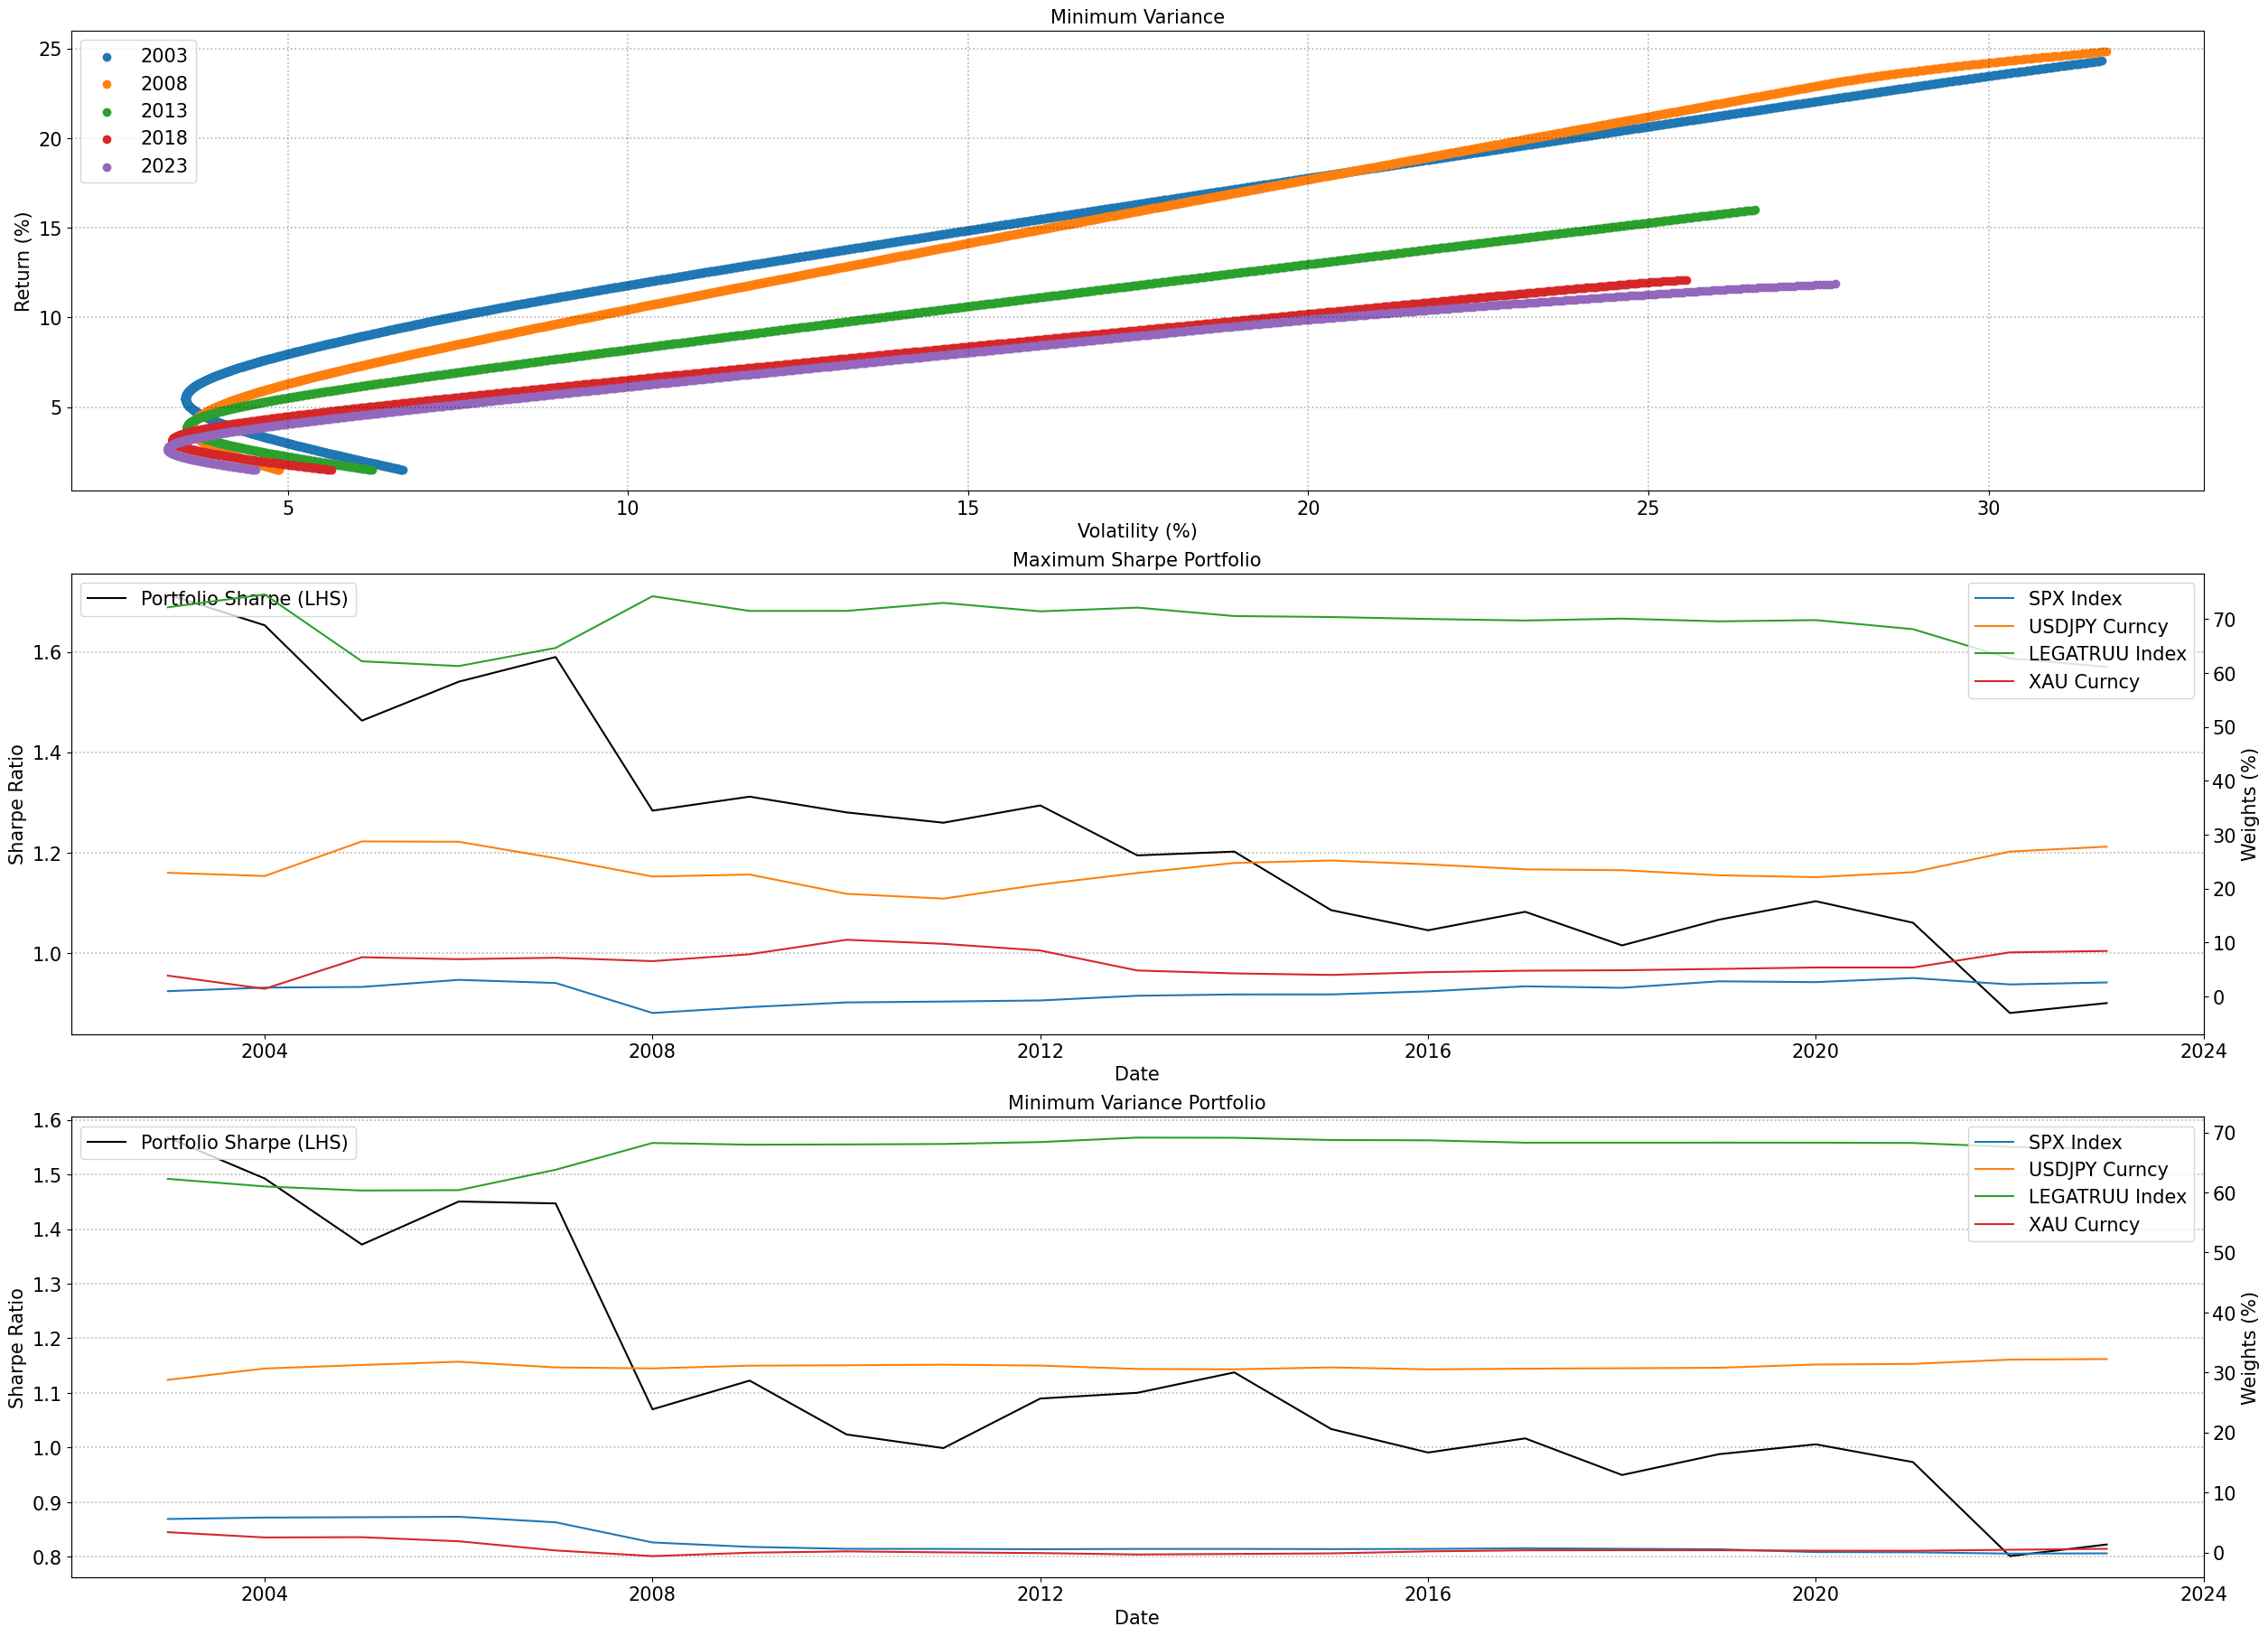

In [82]:
yrList = [i for i in range(2003, 2024, 5)]
size = 15
numC = len(yrList)

fig, ax = plt.subplots(3, 1, figsize=(25, 18), constrained_layout=True)
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, numC)]

for i, colors in enumerate(colors, start=0):
    ax[0].scatter(all_df[all_df.year == yrList[i]].vol * 100, all_df[all_df.year == yrList[i]].ret * 100, label = yrList[i])

ax[0].grid(axis='y', color='black', alpha=0.3, linewidth = 1.2, linestyle = 'dotted')
ax[0].grid(axis='x', color='black', alpha=0.3, linewidth = 1.2, linestyle = 'dotted')
ax[0].set_ylabel("Return (%)", fontsize=size)
ax[0].legend(fontsize=size)
ax[0].set_xlabel("Volatility (%)", fontsize=size)
ax[0].set_title("Minimum Variance", fontsize=size)

ax[1].plot(optWeights.SharpeRatio, label = 'Portfolio Sharpe (LHS)', color='black')
ax[1].legend(loc='upper left', fontsize=size)
ax[1].grid(axis='y', color='black', alpha=0.3, linewidth = 1.2, linestyle = 'dotted')
ax2 = ax[1].twinx()

for asset in port1.columns.values:
    ax2.plot(optWeights[asset] * 100, label = asset)

ax2.legend(loc='upper right', fontsize=size)
ax[1].set_ylabel('Sharpe Ratio', fontsize=size)
ax2.set_ylabel('Weights (%)', fontsize=size)
ax[1].set_xlabel('Date', fontsize=size)
ax2.set_title('Maximum Sharpe Portfolio', fontsize=size)

ax[2].plot(minVarWeights.SharpeRatio, label = 'Portfolio Sharpe (LHS)', color='black')
ax[2].legend(loc='upper left', fontsize=size)
ax[2].grid(axis='y', color='black', alpha=0.3, linewidth = 1.2, linestyle = 'dotted')
ax3 = ax[2].twinx()

for asset in port1.columns.values:
    ax3.plot(minVarWeights[asset] * 100, label = asset)

ax3.legend(loc='upper right', fontsize=size)
ax[2].set_ylabel('Sharpe Ratio', fontsize=size)
ax3.set_ylabel('Weights (%)', fontsize=size)
ax[2].set_xlabel('Date', fontsize=size)
ax3.set_title('Minimum Variance Portfolio', fontsize=size)

for i in [ax[0], ax[1], ax[2], ax2, ax3]:
    i.tick_params(axis = 'y', labelsize = size)
    i.tick_params(axis = 'x', labelsize = size)

#### To identify regimes using asset returns, we extract signals from the persistance of asset returns (price momentum) and CTAs trend following.
#### Rules for asset allocation can be for instance: For Regime 1, increase exposure by 15%. Regime 2, increase exposure to 10%. Regime 3, cut exposure by 5%. Regime 4, cut exposure completely.
#### * This is prob how regime-based asset allocation works when the underlying is not eco data

In [3]:
px_mom = computeMomentum(port1[["SPX Index"]], 1, "2000-01-03", end = "2010-12-31", asset_name = "SPX Index")
px_mom_3 = computeMomentum(port1[["SPX Index"]], 3, "2000-01-03", end = "2010-12-31", asset_name = "SPX Index")
px_mom_6 = computeMomentum(port1[["SPX Index"]], 6, "2000-01-03", end = "2010-12-31", asset_name = "SPX Index")

/Users/clarencetee/Desktop/SMU_MSFE/Regime-Analysis-Positioning/Regime-Analysis-Positioning/functionScripts/functions.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_df_2 = all_df.join(df.Price).drop(['Price_full'], axis=1).fillna(method='ffill')
/Users/clarencetee/Desktop/SMU_MSFE/Regime-Analysis-Positioning/Regime-Analysis-Positioning/functionScripts/functions.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_df_2 = all_df.join(df.Price).drop(['Price_full'], axis=1).fillna(method='ffill')
/Users/clarencetee/Desktop/SMU_MSFE/Regime-Analysis-Positioning/Regime-Analysis-Positioning/functionScripts/functions.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_df_2 = all_df.join(df.Price).drop(['P

##### To think about: 
##### 1) It appears that output from results from an in-sample fit of a Hidden Markov Model on price momentum is no different from simply identifying rules.
##### Eg: HMM simply clusters 6 month returns based on levels, which can be done visually. However, results from the out-of-sample fit could tell a different story.


In [4]:
def fitHMM(asset):
    mod_hmm = hmm.GaussianHMM(n_components=4, covariance_type="full", random_state=42)
    mod_hmm.fit(asset.values.reshape(-1,1))
    return mod_hmm.predict(asset.values.reshape(-1,1))

res_list = []
dict1 = {}
for i in [px_mom.Mth_Prior_1_Return, px_mom_3.Mth_Prior_3_Return, px_mom_6.Mth_Prior_6_Return]:
    i.dropna(inplace=True)
    dict1 = {"Px_mom": i.values, "Regime":fitHMM(i)}
    out_df = pd.DataFrame(dict1, index=i.index)
    out_df.reset_index(inplace=True)
    res_list.append(out_df)

### Price Momentum (1-month)

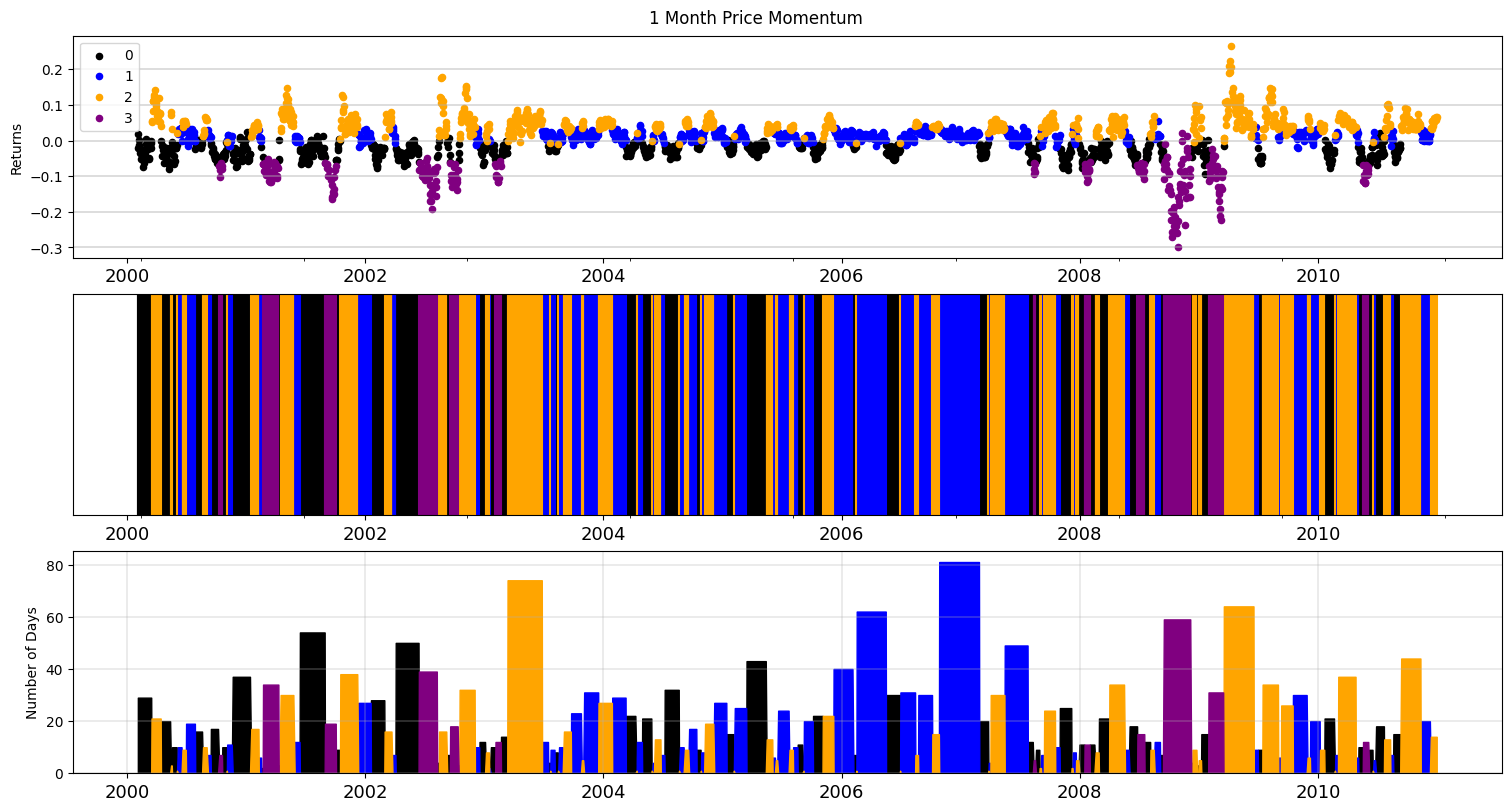

In [5]:
cVal = {0: 'black', 1:'blue', 2:'orange', 3:'purple'}
dts_reg_1 = res_list[0][["date", "Regime"]].set_index("date")
dts_reg_1["R1"] = np.where(dts_reg_1.Regime == 0, 1, 0)
dts_reg_1['r1_consec'] = dts_reg_1.R1.groupby((dts_reg_1.R1 != dts_reg_1.R1.shift()).cumsum()).transform('size') * dts_reg_1.R1
dts_reg_1["R2"] = np.where(dts_reg_1.Regime == 1, 1, 0)
dts_reg_1['r2_consec'] = dts_reg_1.R2.groupby((dts_reg_1.R2 != dts_reg_1.R2.shift()).cumsum()).transform('size') * dts_reg_1.R2
dts_reg_1["R3"] = np.where(dts_reg_1.Regime == 2, 1, 0)
dts_reg_1['r3_consec'] = dts_reg_1.R3.groupby((dts_reg_1.R3 != dts_reg_1.R3.shift()).cumsum()).transform('size') * dts_reg_1.R3
dts_reg_1["R4"] = np.where(dts_reg_1.Regime == 3, 1, 0)
dts_reg_1['r4_consec'] = dts_reg_1.R4.groupby((dts_reg_1.R4 != dts_reg_1.R4.shift()).cumsum()).transform('size') * dts_reg_1.R4

px_reg_1 = pd.concat([port1[["SPX Index"]], dts_reg_1], axis=1).dropna()

fig, ax = plt.subplots(3, 1, figsize = (15, 8), constrained_layout = True)
ax[0].sharex(ax[1])
grped = res_list[0].groupby('Regime')

for k, g in grped:
    g.plot(ax = ax[0], kind = 'scatter', x = 'date', y = 'Px_mom', label = k, color = cVal[k])

ax[0].grid(axis='y', linewidth=1.2, alpha=0.5)
ax[0].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)
# ax[0].axhline(0.10, color = 'maroon', alpha = 0.7, linestyle = "dotted")
# ax[0].axhline(0.03, color = 'forestgreen', alpha = 0.9, linestyle = "dotted")
# ax[0].axhline(-0.07, color = 'red', alpha = 0.9, linestyle = "dotted")
# ax[0].axhline(-0.15, color = 'dodgerblue', alpha = 0.7, linestyle = "dotted")
ax[0].set_ylabel("Returns")

for i in px_reg_1[px_reg_1.Regime == 0].index:
    ax[1].axvline(i, label = "Regime 1", color = cVal[0])

for i in px_reg_1[px_reg_1.Regime == 1].index:
    ax[1].axvline(i, label = "Regime 2", color = cVal[1])

for i in px_reg_1[px_reg_1.Regime == 2].index:
    ax[1].axvline(i, label = "Regime 3", color = cVal[2])

for i in px_reg_1[px_reg_1.Regime == 3].index:
    ax[1].axvline(i, label = "Regime 4", color = cVal[3])

ax[1].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)
ax[1].set_yticks([])

ax[2].stackplot(dts_reg_1.index, dts_reg_1['r1_consec'].values, color = cVal[0])
ax[2].stackplot(dts_reg_1.index, dts_reg_1['r2_consec'].values, color = cVal[1])
ax[2].stackplot(dts_reg_1.index, dts_reg_1['r3_consec'].values, color = cVal[2])
ax[2].stackplot(dts_reg_1.index, dts_reg_1['r4_consec'].values, color = cVal[3])
ax[2].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)
ax[2].grid(axis='y', linewidth=1.2, alpha=0.3)
ax[2].grid(axis='x', linewidth=1.2, alpha=0.3)
ax[2].set_ylabel('Number of Days')


fig.suptitle("1 Month Price Momentum")
plt.show()

### Price Momentum (3-months)

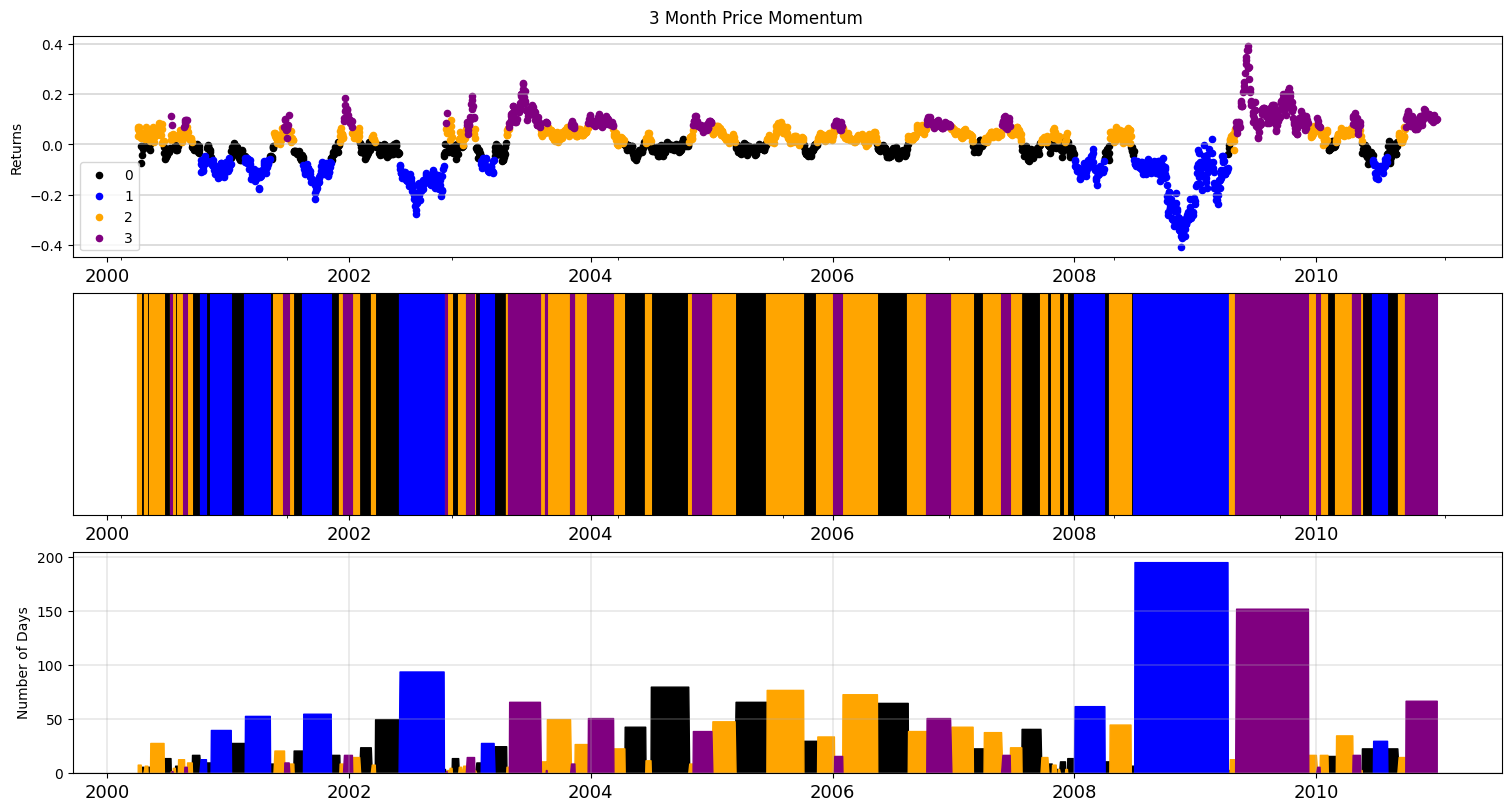

In [6]:
cVal = {0: 'black', 1:'blue', 2:'orange', 3:'purple'}
dts_reg_3 = res_list[1].set_index("date")

dts_reg_3["R1"] = np.where(dts_reg_3.Regime == 0, 1, 0)
dts_reg_3['r1_consec'] = dts_reg_3.R1.groupby((dts_reg_3.R1 != dts_reg_3.R1.shift()).cumsum()).transform('size') * dts_reg_3.R1
dts_reg_3["R2"] = np.where(dts_reg_3.Regime == 1, 1, 0)
dts_reg_3['r2_consec'] = dts_reg_3.R2.groupby((dts_reg_3.R2 != dts_reg_3.R2.shift()).cumsum()).transform('size') * dts_reg_3.R2
dts_reg_3["R3"] = np.where(dts_reg_3.Regime == 2, 1, 0)
dts_reg_3['r3_consec'] = dts_reg_3.R3.groupby((dts_reg_3.R3 != dts_reg_3.R3.shift()).cumsum()).transform('size') * dts_reg_3.R3
dts_reg_3["R4"] = np.where(dts_reg_3.Regime == 3, 1, 0)
dts_reg_3['r4_consec'] = dts_reg_3.R4.groupby((dts_reg_3.R4 != dts_reg_3.R4.shift()).cumsum()).transform('size') * dts_reg_3.R4

px_reg_3 = pd.concat([port1[["SPX Index"]], dts_reg_3], axis=1).dropna()
allAssets_3 = pd.concat([port1, dts_reg_3], axis=1).dropna()

fig, ax = plt.subplots(3, 1, figsize = (15, 8), constrained_layout = True)
ax[0].sharex(ax[1])
grped = res_list[1].groupby('Regime')

for k, g in grped:
    g.plot(ax = ax[0], kind = 'scatter', x = 'date', y = 'Px_mom', label = k, color = cVal[k])

ax[0].grid(axis='y', linewidth=1.2, alpha=0.5)
ax[0].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)
# ax[0].axhline(0.06, color = 'maroon', alpha = 0.7, linestyle = "dotted")
# ax[0].axhline(0, color = 'forestgreen', alpha = 0.9, linestyle = "dotted")
# ax[0].axhline(-0.05, color = 'red', alpha = 0.9, linestyle = "dotted")
# ax[0].axhline(-0.15, color = 'dodgerblue', alpha = 0.7, linestyle = "dotted")
ax[0].set_ylabel("Returns")

for i in px_reg_3[px_reg_3.Regime == 0].index:
    ax[1].axvline(i, label = "Regime 1", color = cVal[0])

for i in px_reg_3[px_reg_3.Regime == 1].index:
    ax[1].axvline(i, label = "Regime 2", color = cVal[1])

for i in px_reg_3[px_reg_3.Regime == 2].index:
    ax[1].axvline(i, label = "Regime 3", color = cVal[2])

for i in px_reg_3[px_reg_3.Regime == 3].index:
    ax[1].axvline(i, label = "Regime 4", color = cVal[3])

ax[1].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)
ax[1].set_yticks([])

ax[2].stackplot(dts_reg_3.index, dts_reg_3['r1_consec'].values, color = cVal[0])
ax[2].stackplot(dts_reg_3.index, dts_reg_3['r2_consec'].values, color = cVal[1])
ax[2].stackplot(dts_reg_3.index, dts_reg_3['r3_consec'].values, color = cVal[2])
ax[2].stackplot(dts_reg_3.index, dts_reg_3['r4_consec'].values, color = cVal[3])
ax[2].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)
ax[2].grid(axis='y', linewidth=1.2, alpha=0.3)
ax[2].grid(axis='x', linewidth=1.2, alpha=0.3)
ax[2].set_ylabel('Number of Days')

fig.suptitle("3 Month Price Momentum")
plt.show()

### Price Momentum (6-months)

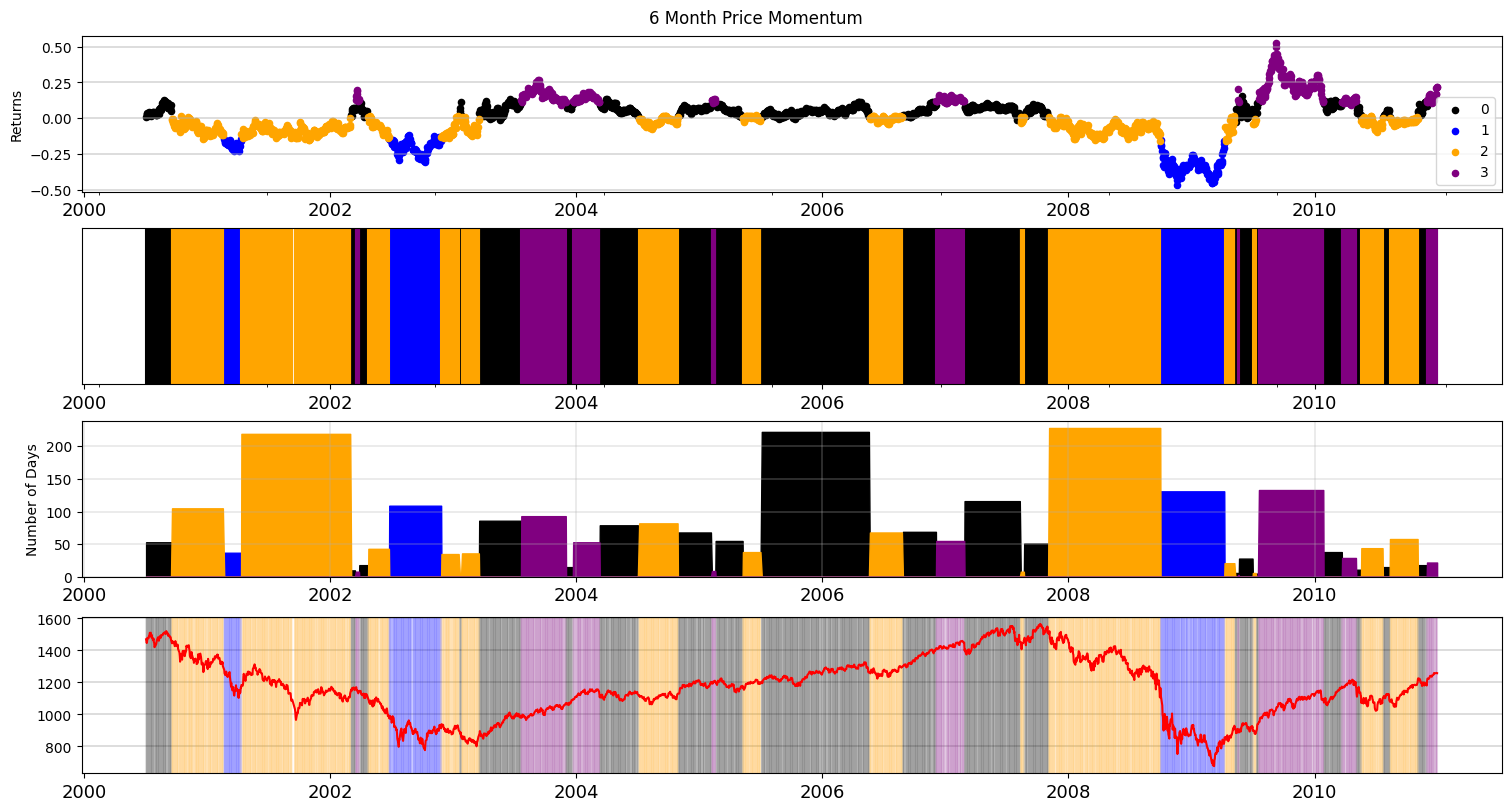

In [7]:
cVal = {0: 'black', 1:'blue', 2:'orange', 3:'purple'}
dts_reg_6 = res_list[2][["date", "Regime"]].set_index("date")

dts_reg_6["R1"] = np.where(dts_reg_6.Regime == 0, 1, 0)
dts_reg_6['r1_consec'] = dts_reg_6.R1.groupby((dts_reg_6.R1 != dts_reg_6.R1.shift()).cumsum()).transform('size') * dts_reg_6.R1
dts_reg_6["R2"] = np.where(dts_reg_6.Regime == 1, 1, 0)
dts_reg_6['r2_consec'] = dts_reg_6.R2.groupby((dts_reg_6.R2 != dts_reg_6.R2.shift()).cumsum()).transform('size') * dts_reg_6.R2
dts_reg_6["R3"] = np.where(dts_reg_6.Regime == 2, 1, 0)
dts_reg_6['r3_consec'] = dts_reg_6.R3.groupby((dts_reg_6.R3 != dts_reg_6.R3.shift()).cumsum()).transform('size') * dts_reg_6.R3
dts_reg_6["R4"] = np.where(dts_reg_6.Regime == 3, 1, 0)
dts_reg_6['r4_consec'] = dts_reg_6.R4.groupby((dts_reg_6.R4 != dts_reg_6.R4.shift()).cumsum()).transform('size') * dts_reg_6.R4

px_reg_6 = pd.concat([port1[["SPX Index"]], dts_reg_6], axis=1).dropna()
allAssets_6 = pd.concat([port1, dts_reg_6], axis=1).dropna()

fig, ax = plt.subplots(4, 1, figsize = (15, 8), constrained_layout = True)
ax[0].sharex(ax[1])
grped = res_list[2].groupby('Regime')

for k, g in grped:
    g.plot(ax = ax[0], kind = 'scatter', x = 'date', y = 'Px_mom', label = k, color = cVal[k])

ax[0].grid(axis='y', linewidth=1.2, alpha=0.5)
ax[0].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)
# ax[0].axhline(0.06, color = 'maroon', alpha = 0.7, linestyle = "dotted")
# ax[0].axhline(0, color = 'forestgreen', alpha = 0.9, linestyle = "dotted")
# ax[0].axhline(-0.07, color = 'red', alpha = 0.9, linestyle = "dotted")
# ax[0].axhline(-0.15, color = 'dodgerblue', alpha = 0.7, linestyle = "dotted")
ax[0].set_ylabel("Returns")

for i in px_reg_6[px_reg_6.Regime == 0].index:
    ax[1].axvline(i, label = "Regime 1", color = cVal[0])
    ax[3].axvline(i, label = "Regime 1", color = cVal[0], alpha = 0.1)

for i in px_reg_6[px_reg_6.Regime == 1].index:
    ax[1].axvline(i, label = "Regime 2", color = cVal[1])
    ax[3].axvline(i, label = "Regime 1", color = cVal[1], alpha = 0.1)

for i in px_reg_6[px_reg_6.Regime == 2].index:
    ax[1].axvline(i, label = "Regime 3", color = cVal[2])
    ax[3].axvline(i, label = "Regime 1", color = cVal[2], alpha = 0.1)

for i in px_reg_6[px_reg_6.Regime == 3].index:
    ax[1].axvline(i, label = "Regime 4", color = cVal[3])
    ax[3].axvline(i, label = "Regime 1", color = cVal[3], alpha = 0.1)

ax[1].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)
ax[1].set_yticks([])

ax[2].stackplot(dts_reg_6.index, dts_reg_6['r1_consec'].values, color = cVal[0])
ax[2].stackplot(dts_reg_6.index, dts_reg_6['r2_consec'].values, color = cVal[1])
ax[2].stackplot(dts_reg_6.index, dts_reg_6['r3_consec'].values, color = cVal[2])
ax[2].stackplot(dts_reg_6.index, dts_reg_6['r4_consec'].values, color = cVal[3])
ax[2].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)
ax[2].grid(axis='y', linewidth=1.2, alpha=0.3)
ax[2].grid(axis='x', linewidth=1.2, alpha=0.3)
ax[2].set_ylabel('Number of Days')

ax[3].plot(px_reg_6[["SPX Index"]], color = "red", label = "SPX Index")
ax[3].grid(axis='y', linewidth=1.2, alpha=0.5)
ax[3].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)

fig.suptitle("6 Month Price Momentum")
plt.show()

In [8]:
#### After fixing regimes, decide on asset allocation:

#### Regime 1: 60% equity, 40% bonds, 0% gold
def reg1():
    return np.array([0.6, 0.4, 0])

#### Regime 2: 50% equity, 45% bonds, 5% gold
def reg2():
    return np.array([0.5, 0.45, 0.05])

#### Regime 3: 30% equity, 60% bonds, 10% gold
def reg3():
    return np.array([0.3, 0.6, 0.10])

#### Regime 4: 20% equity, 65% bonds, 15% gold
def reg4():
    return np.array([0.2, 0.65, 0.15])


#### In-sample fit and performance

In [9]:
## Adjusting for one-day lag
allAssets_6["SPX_Ret"] = allAssets_6[["SPX Index"]].pct_change()
allAssets_6["Bnd_Ret"] = allAssets_6[["LEGATRUU Index"]].pct_change()
allAssets_6["Gld_Ret"] = allAssets_6[["XAU Curncy"]].pct_change()
allAssets_6['Shifted_Reg'] = allAssets_6['Regime'].shift(1)

ret1 = allAssets_6[allAssets_6.Shifted_Reg == 3][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]] @ reg1()
ret2 = allAssets_6[allAssets_6.Shifted_Reg == 0][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]] @ reg2()
ret3 = allAssets_6[allAssets_6.Shifted_Reg == 2][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]] @ reg3()
ret4 = allAssets_6[allAssets_6.Shifted_Reg == 1][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]] @ reg4()
allAssets_6["Adj_Port_Returns"] = pd.concat([ret1, ret2, ret3, ret4], axis=0)
allAssets_6.index.name = 'date'

Text(0.5, 0, 'Date')

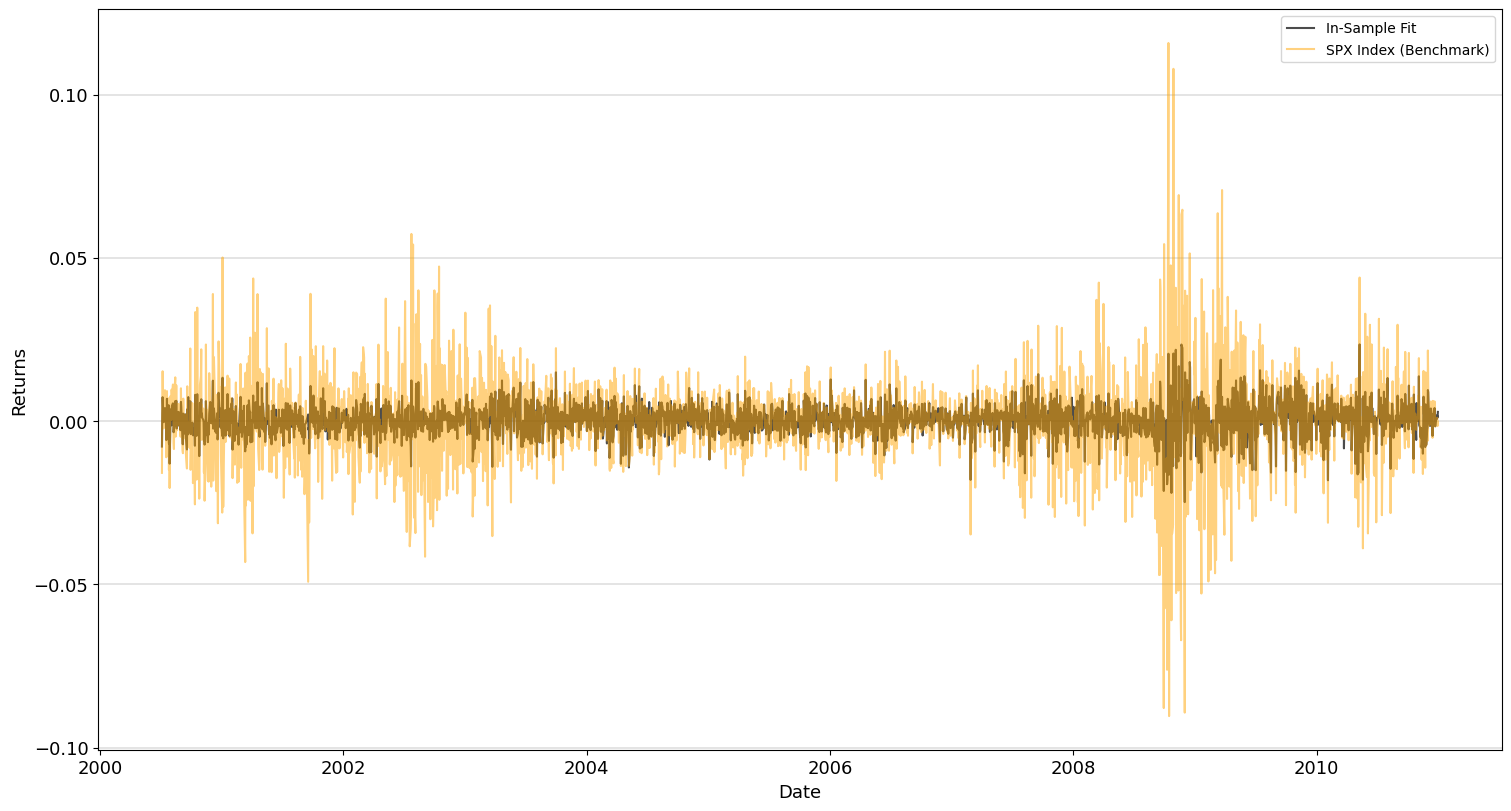

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8), constrained_layout = True)
ax.plot(allAssets_6["Adj_Port_Returns"], label = "In-Sample Fit", alpha = 0.7, color = 'black')
ax.plot(allAssets_6["SPX_Ret"], label = "SPX Index (Benchmark)", alpha = 0.5, color = 'orange')
ax.grid(axis='y', linewidth = 1.2, alpha = 0.4)
ax.xaxis.set_tick_params(which='both', labelsize=13)
ax.yaxis.set_tick_params(which='both', labelsize=13)
ax.legend()
ax.set_ylabel("Returns", fontsize=13)
ax.set_xlabel("Date", fontsize=13)

In [11]:
exportPerformanceMetrics(allAssets_6["Adj_Port_Returns"], allAssets_6["SPX_Ret"])

Strategy Benchmark
Performance Metrics (2000-07-03 till 2010-12-31)                   
CAGR %                                              6.13%    -1.48%
Volatility                                          7.77%    21.74%
Sharpe Ratio                                         0.79     -0.07
Max Drawdown %                                    -18.61%   -56.78%
Return/MaxDrawdown                                   0.33      0.03

#### Recursive (Expanding Window) Scheme 

In [12]:
def recursiveScheme(df, nFcst):
    """
    Recursive scheme for model fitting and forecasting 1-step ahead

    Parameters
    ----------
    df : pandas dataframe with a datetime index specified, univariate time series
    nFcst : int, number of 1-step ahead forecasts to generate

    Returns
    -------
    est : list of forecasts
    
    """
    nrow = df.shape[0] - nFcst
    pred = []
    mod_hmm = hmm.GaussianHMM(n_components=4, covariance_type="full", random_state=42)

    for i in range(nFcst):
        trainSet = df.iloc[0:(nrow+i)]
        testSet = df.iloc[(nrow+i)]
        # Fit a linear regression to test
        mod_hmm.fit(trainSet.values.reshape(-1,1))
        predReg = pd.Series(data = mod_hmm.predict(testSet.reshape(-1, 1)), index = [df.index[(nrow+i)]])
        pred.append(predReg)

    return pd.concat(pred, axis=0)

predVar_recur = recursiveScheme(px_mom_6.Mth_Prior_6_Return, 2000)

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


In [13]:
predVar_recur.name = "Pred_Recurv"
recurvScheme = pd.concat([allAssets_6[["SPX_Ret", "Bnd_Ret", "Gld_Ret"]], predVar_recur], axis=1).dropna()
recurvScheme['Pred_Recurv_Adj'] = recurvScheme['Pred_Recurv'].shift(1)

ret1 = recurvScheme[recurvScheme.Pred_Recurv_Adj == 3][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]] @ reg1()
ret2 = recurvScheme[recurvScheme.Pred_Recurv_Adj == 0][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]] @ reg2()
ret3 = recurvScheme[recurvScheme.Pred_Recurv_Adj == 2][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]] @ reg3()
ret4 = recurvScheme[recurvScheme.Pred_Recurv_Adj == 1][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]] @ reg4()

recurvScheme["Adj_Port_Returns"] = pd.concat([ret1, ret2, ret3, ret4], axis=0)
recurvScheme.index.name = "date"

Text(0.5, 0, 'Date')

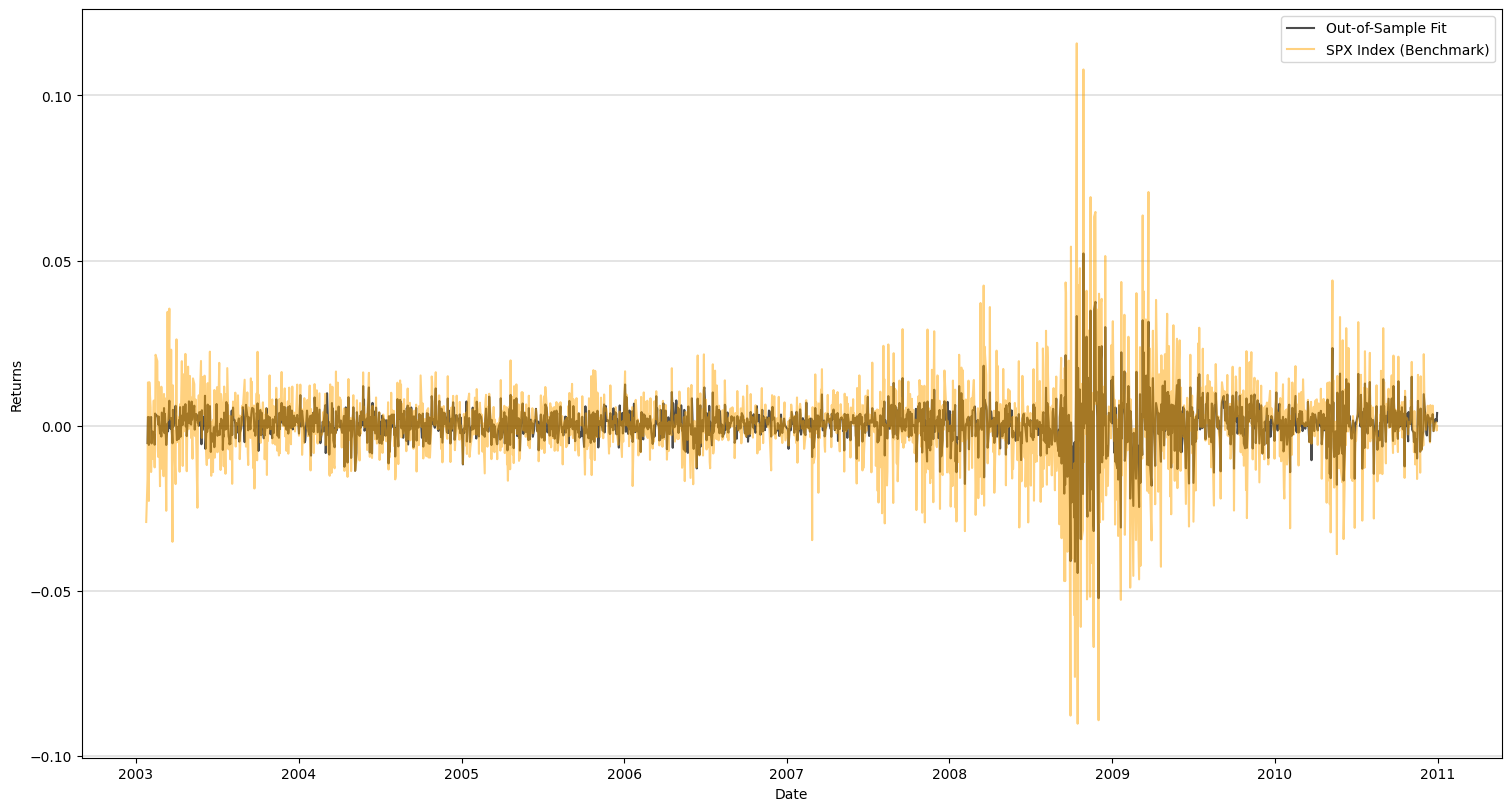

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8), constrained_layout = True)
ax.plot(recurvScheme["Adj_Port_Returns"], label = "Out-of-Sample Fit", alpha = 0.7, color = 'black')
ax.plot(recurvScheme["SPX_Ret"], label = "SPX Index (Benchmark)", alpha = 0.5, color = 'orange')
ax.grid(axis='y', linewidth = 1.2, alpha = 0.4)
ax.legend()
ax.set_ylabel("Returns")
ax.set_xlabel("Date")

In [15]:
exportPerformanceMetrics(recurvScheme["Adj_Port_Returns"], recurvScheme["SPX_Ret"])

Strategy Benchmark
Performance Metrics (2003-01-24 till 2010-12-31)                   
CAGR %                                              6.24%     4.49%
Volatility                                         10.10%    21.29%
Sharpe Ratio                                         0.62      0.21
Max Drawdown %                                    -34.20%   -56.78%
Return/MaxDrawdown                                   0.18      0.08

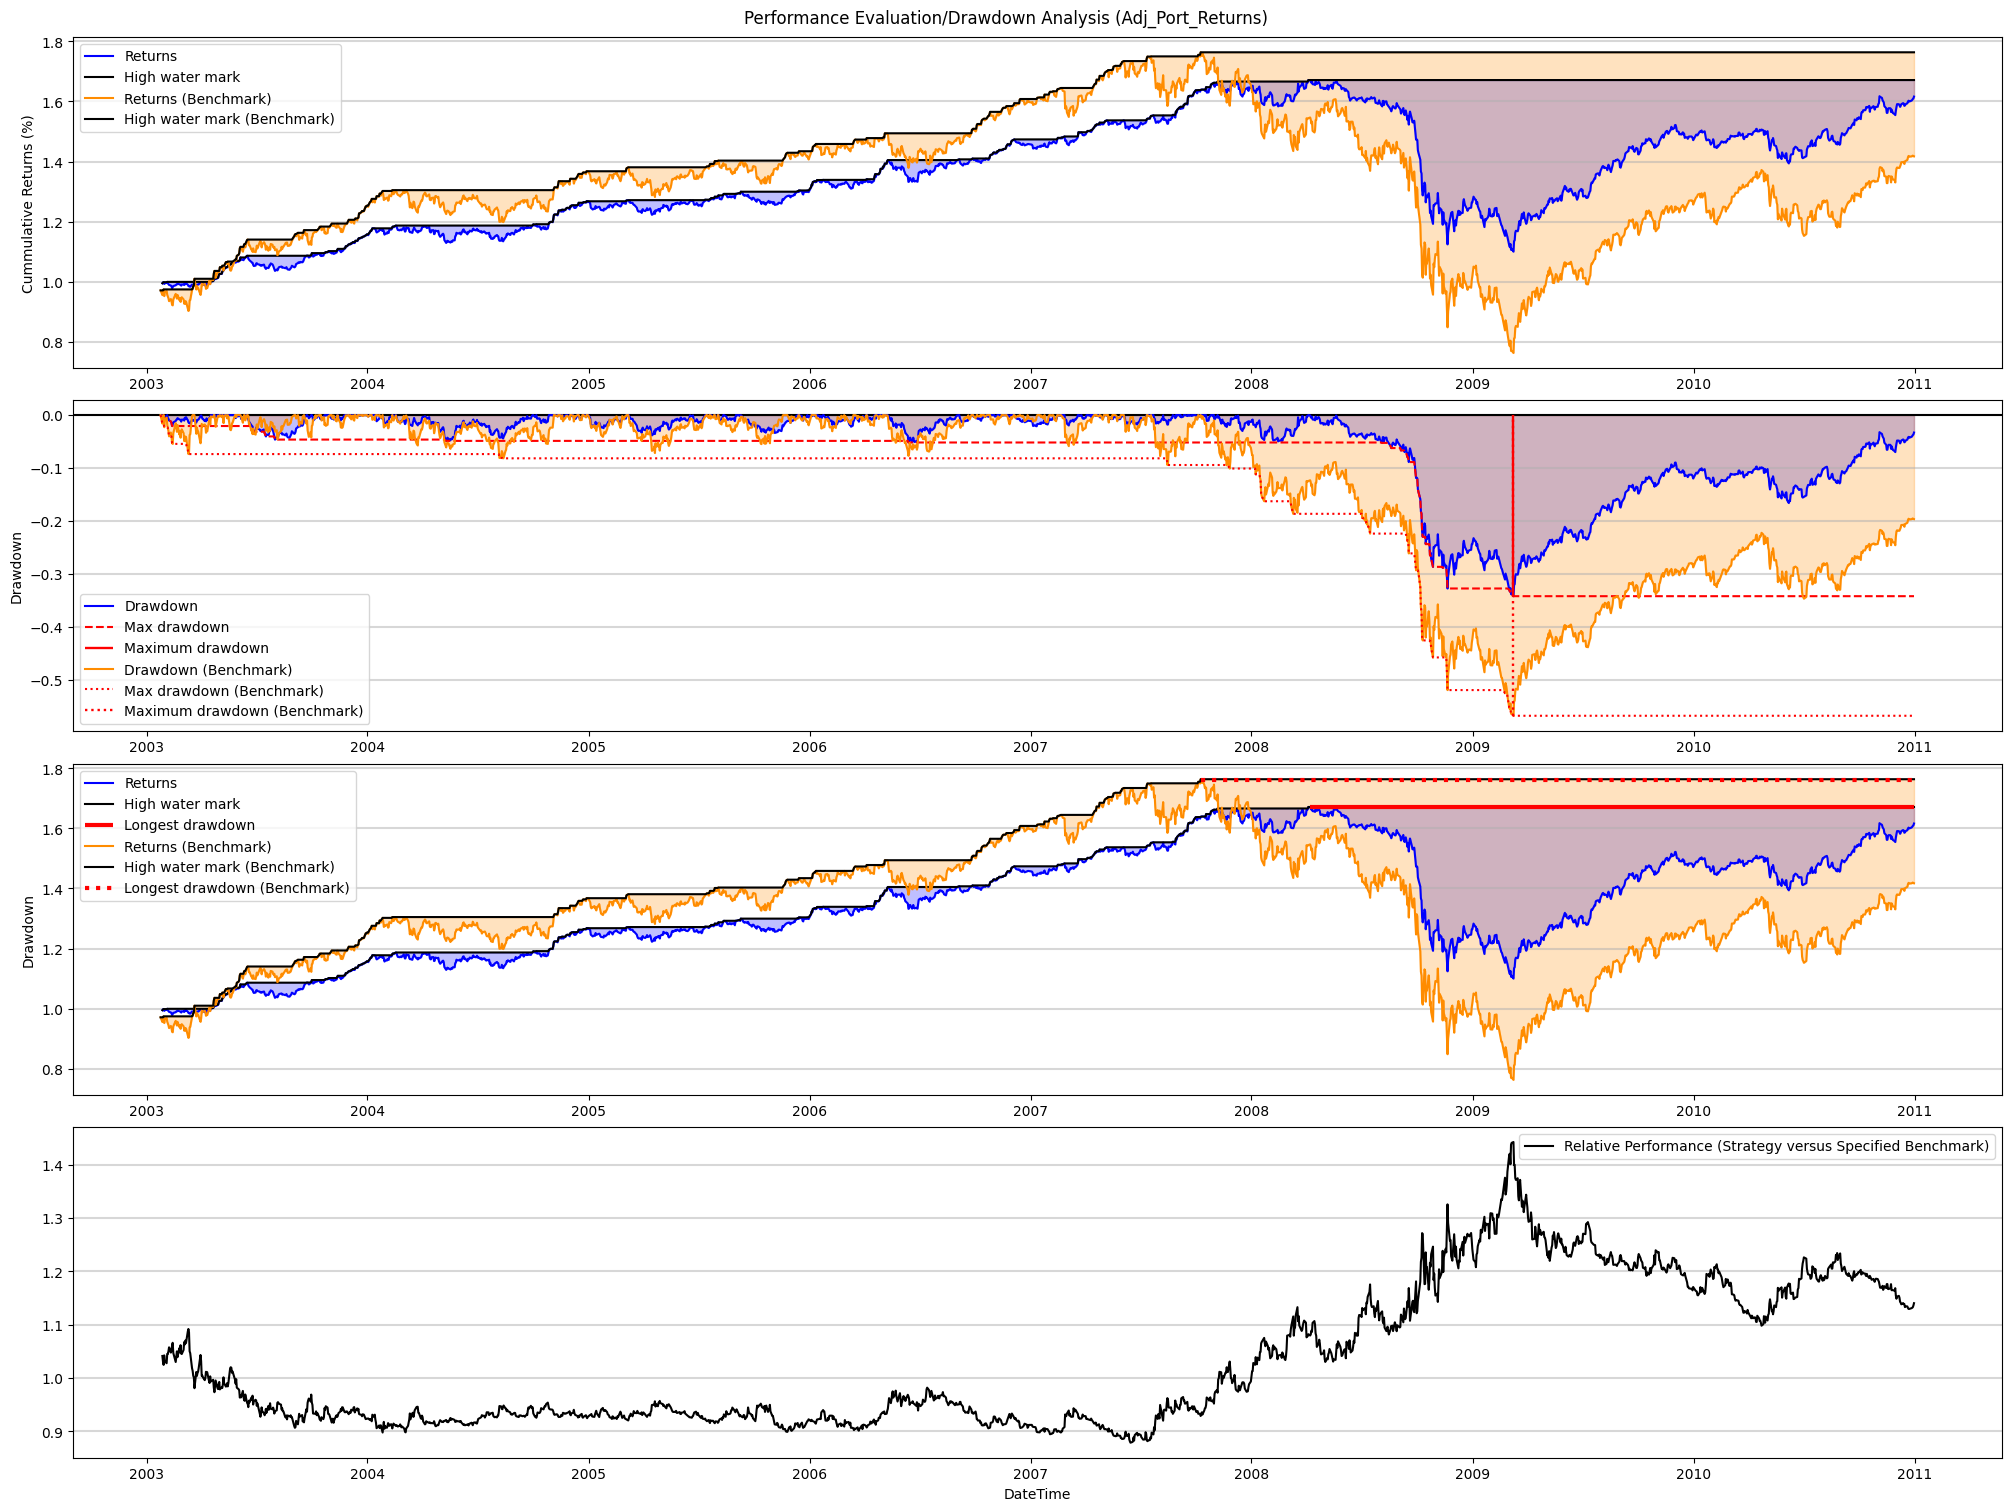

In [16]:
drawdownCharts(recurvScheme["Adj_Port_Returns"], benchmark = recurvScheme["SPX_Ret"], includeBenchmark = True, showPlot=True)

#### Rolling Scheme

In [17]:
def rollingScheme(df, trainingWindowSize):
    """
    Rolling scheme for fitting HMM to predict regimes for the next 1-step ahead

    Parameters
    ----------
    df : pd.Series with DatetimeIndex
    trainingWindowSize : int

    Returns
    -------

    """

    last_idx = len(df) - trainingWindowSize
    pred = []
    # Initialize the model
    mod_hmm = hmm.GaussianHMM(n_components=4, covariance_type="full", random_state=42)

    for i in range(last_idx):
        trainSet = df.iloc[i:(i + trainingWindowSize)]
        testSet = df.iloc[(i + trainingWindowSize):(i + 1 + trainingWindowSize)]
        
        mod_hmm.fit(trainSet.values.reshape(-1,1))
        predReg = pd.Series(data = mod_hmm.predict(testSet.values.reshape(-1,1)), index = testSet.index)
        pred.append(predReg)
        
    return pd.concat(pred, axis=0)

predVar = rollingScheme(px_mom_6.Mth_Prior_6_Return, 500)

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


In [18]:
predVar.name = "Predicted Regimes"
rollScheme = pd.concat([allAssets_6[["SPX_Ret", "Bnd_Ret", "Gld_Ret"]], predVar], axis=1).dropna()
# Include a lag of one day
rollScheme['Adj_Pred_Regimes'] = rollScheme['Predicted Regimes'].shift(1)

ret1 = rollScheme[rollScheme.Adj_Pred_Regimes == 3][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]] @ reg1()
ret2 = rollScheme[rollScheme.Adj_Pred_Regimes == 0][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]] @ reg2()
ret3 = rollScheme[rollScheme.Adj_Pred_Regimes == 2][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]] @ reg3()
ret4 = rollScheme[rollScheme.Adj_Pred_Regimes == 1][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]] @ reg4()
rollScheme["Adj_Port_Returns"] = pd.concat([ret1, ret2, ret3, ret4], axis=0)
rollScheme.index.name = "date"

Text(0.5, 0, 'Date')

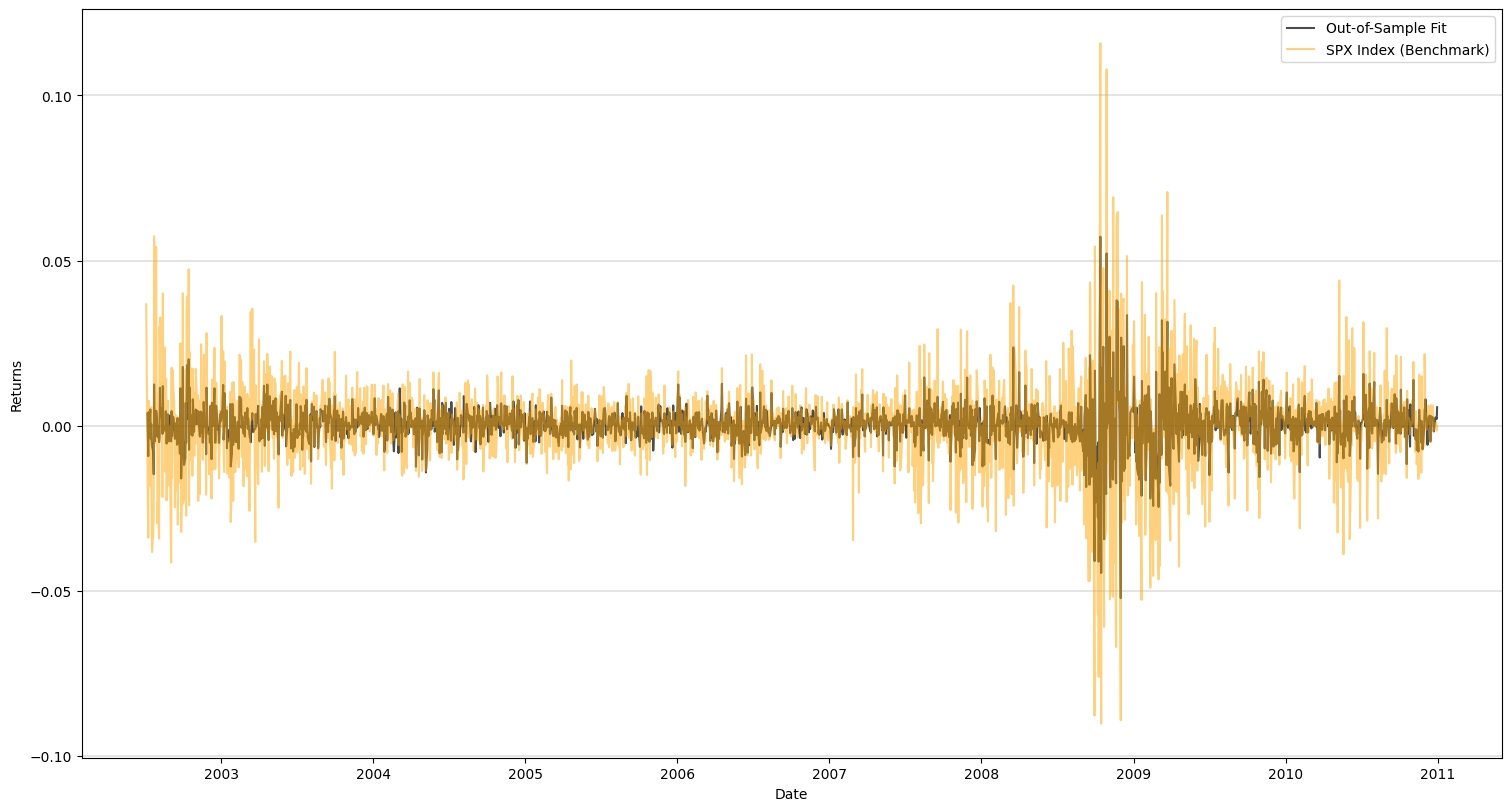

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8), constrained_layout = True)
ax.plot(rollScheme["Adj_Port_Returns"], label = "Out-of-Sample Fit", alpha = 0.7, color = 'black')
ax.plot(rollScheme["SPX_Ret"], label = "SPX Index (Benchmark)", alpha = 0.5, color = 'orange')
ax.grid(axis='y', linewidth = 1.2, alpha = 0.4)
ax.legend()
ax.set_ylabel("Returns")
ax.set_xlabel("Date")

In [20]:
exportPerformanceMetrics(rollScheme["Adj_Port_Returns"], rollScheme["SPX_Ret"])

Strategy Benchmark
Performance Metrics (2002-07-05 till 2010-12-31)                   
CAGR %                                              8.18%     3.31%
Volatility                                          9.82%    22.04%
Sharpe Ratio                                         0.83      0.15
Max Drawdown %                                    -27.02%   -56.78%
Return/MaxDrawdown                                   0.30      0.06

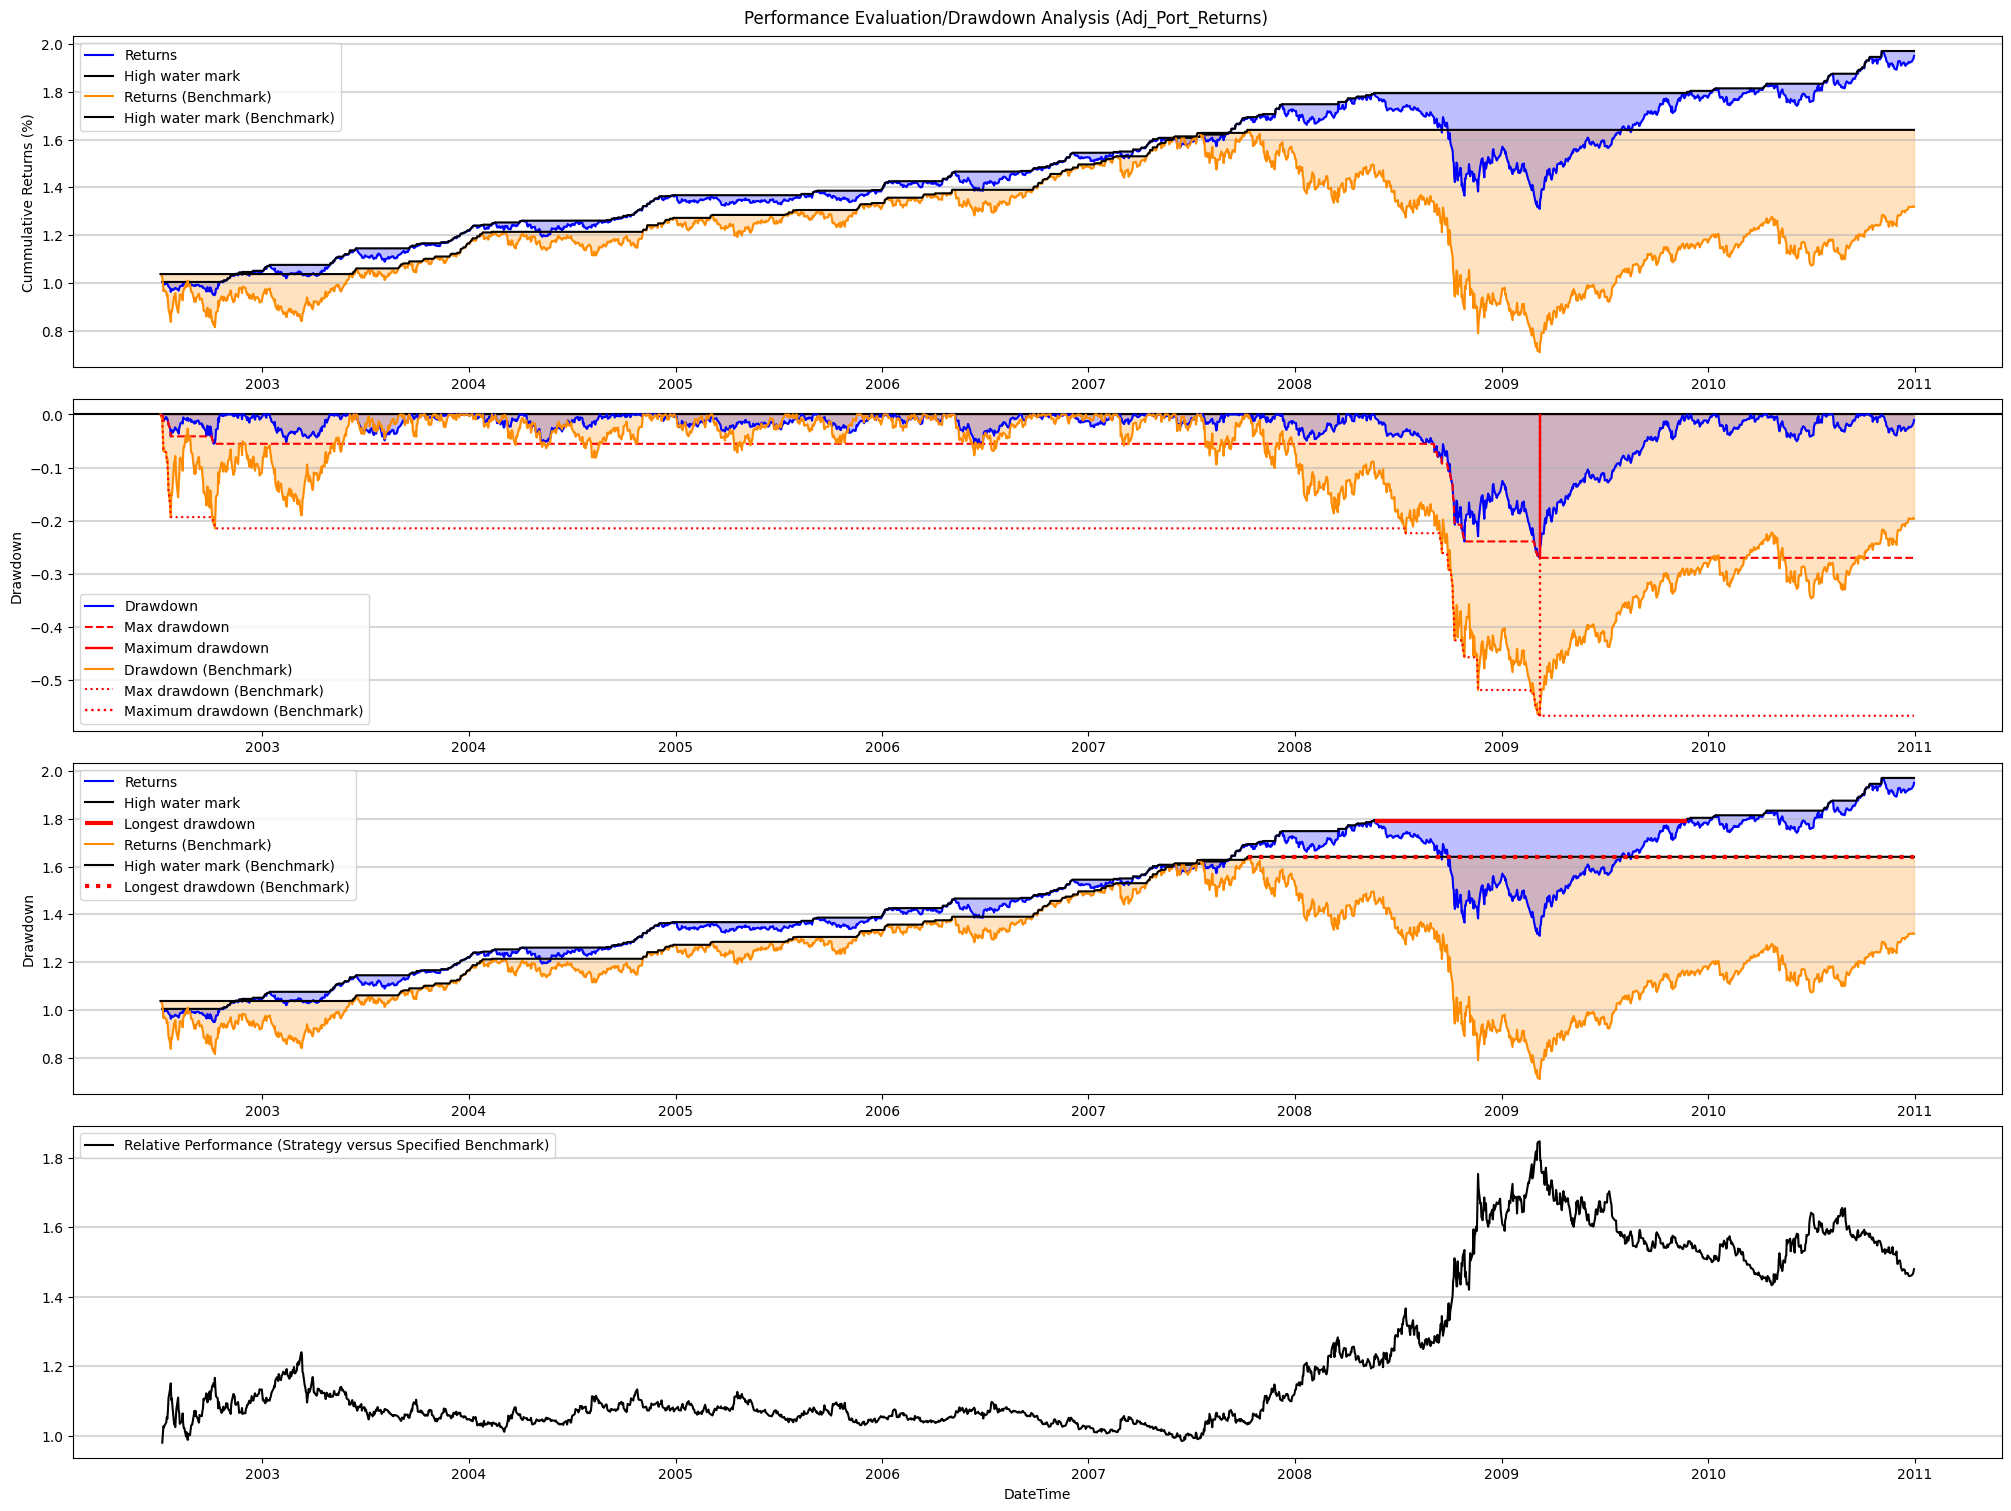

In [21]:
drawdownCharts(rollScheme["Adj_Port_Returns"], benchmark = rollScheme["SPX_Ret"], includeBenchmark = True, showPlot=True)

#### Correlation analysis of SPX, LEGATRUU & XAU

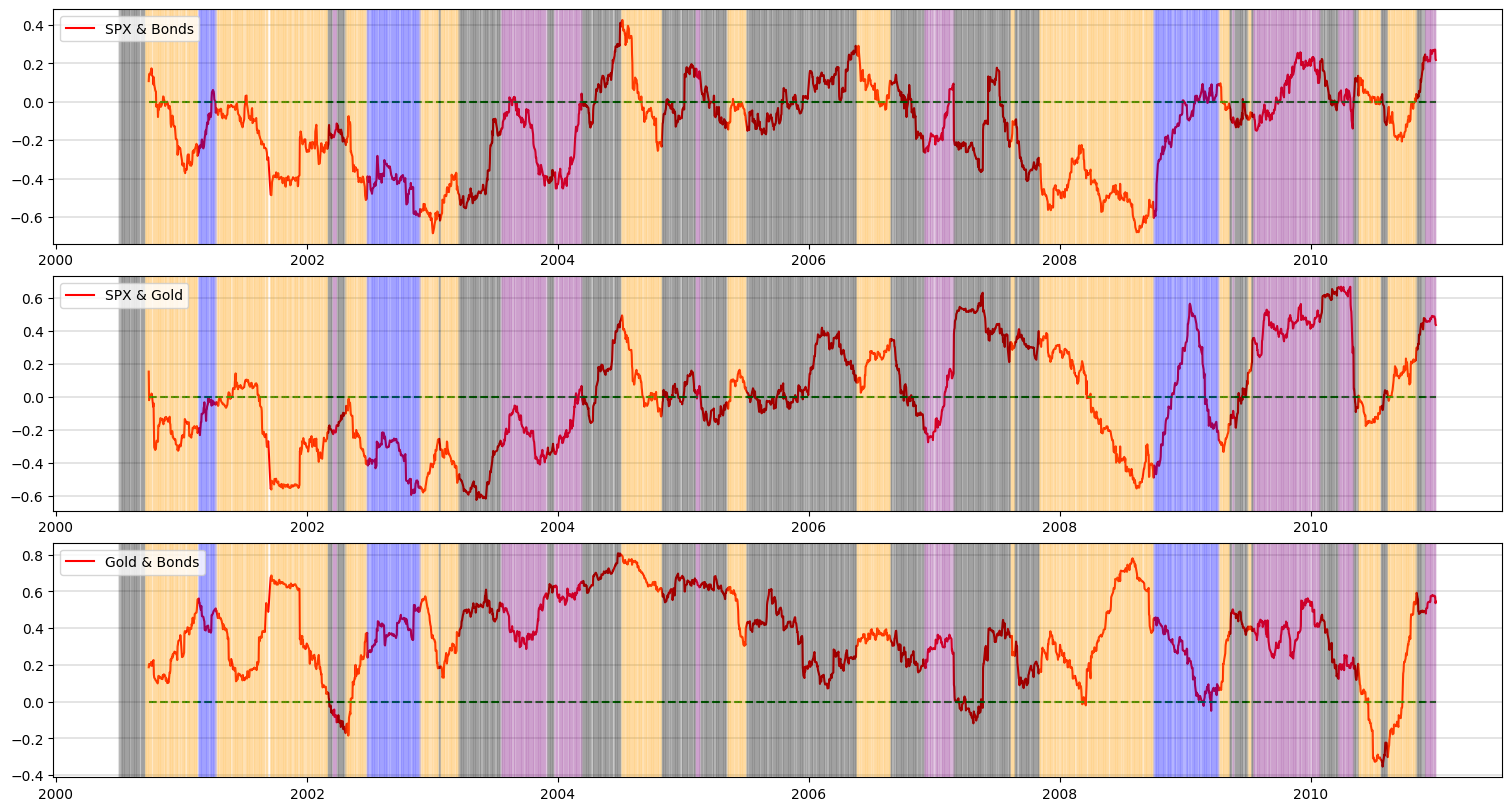

In [22]:
cVal = {0: 'black', 1:'blue', 2:'orange', 3:'purple'}
alphaVal = 0.1
spx_bnd_roll = allAssets_6[["SPX_Ret", "Bnd_Ret", "Gld_Ret"]].rolling(60).corr().dropna().loc[(slice(None), ["SPX_Ret"]), ].droplevel(1).Bnd_Ret
spx_gld_roll = allAssets_6[["SPX_Ret", "Bnd_Ret", "Gld_Ret"]].rolling(60).corr().dropna().loc[(slice(None), ["SPX_Ret"]), ].droplevel(1).Gld_Ret
bnd_gld_roll = allAssets_6[["SPX_Ret", "Bnd_Ret", "Gld_Ret"]].rolling(60).corr().dropna().loc[(slice(None), ["Bnd_Ret"]), ].droplevel(1).Gld_Ret

fig, ax = plt.subplots(3, 1, figsize=(15, 8), constrained_layout=True, sharex=True)
ax[0].plot(spx_bnd_roll, label = "SPX & Bonds", color="red")
ax[0].legend()
ax[0].xaxis.set_tick_params(which='both', labelbottom=True)
ax[0].grid(axis='y', linewidth = 1.2, alpha = 0.4)
ax[0].hlines(y = 0, xmin = spx_bnd_roll.index[0], xmax = spx_bnd_roll.index[-1], linestyle = "dashed", color="green")

for i in px_reg_6[px_reg_6.Regime == 0].index:
    ax[0].axvline(i, label = "Regime 1", color = cVal[0], alpha = alphaVal)

for i in px_reg_6[px_reg_6.Regime == 1].index:
    ax[0].axvline(i, label = "Regime 2", color = cVal[1], alpha = alphaVal)

for i in px_reg_6[px_reg_6.Regime == 2].index:
    ax[0].axvline(i, label = "Regime 3", color = cVal[2], alpha = alphaVal)

for i in px_reg_6[px_reg_6.Regime == 3].index:
    ax[0].axvline(i, label = "Regime 4", color = cVal[3], alpha = alphaVal)

ax[1].plot(spx_gld_roll, label = "SPX & Gold", color="red")
ax[1].legend()
ax[1].grid(axis='y', linewidth = 1.2, alpha = 0.4)
ax[1].xaxis.set_tick_params(which='both', labelbottom=True)
ax[1].hlines(y = 0, xmin = spx_gld_roll.index[0], xmax = spx_gld_roll.index[-1], linestyle = "dashed", color="green")

for i in px_reg_6[px_reg_6.Regime == 0].index:
    ax[1].axvline(i, label = "Regime 1", color = cVal[0], alpha = alphaVal)

for i in px_reg_6[px_reg_6.Regime == 1].index:
    ax[1].axvline(i, label = "Regime 2", color = cVal[1], alpha = alphaVal)

for i in px_reg_6[px_reg_6.Regime == 2].index:
    ax[1].axvline(i, label = "Regime 3", color = cVal[2], alpha = alphaVal)

for i in px_reg_6[px_reg_6.Regime == 3].index:
    ax[1].axvline(i, label = "Regime 4", color = cVal[3], alpha = alphaVal)

ax[2].plot(bnd_gld_roll, label = "Gold & Bonds", color="red")
ax[2].legend()
ax[2].grid(axis='y', linewidth = 1.2, alpha = 0.4)
ax[2].xaxis.set_tick_params(which='both', labelbottom=True)
ax[2].hlines(y = 0, xmin = bnd_gld_roll.index[0], xmax = bnd_gld_roll.index[-1], linestyle = "dashed", color="green")

for i in px_reg_6[px_reg_6.Regime == 0].index:
    ax[2].axvline(i, label = "Regime 1", color = cVal[0], alpha = alphaVal)

for i in px_reg_6[px_reg_6.Regime == 1].index:
    ax[2].axvline(i, label = "Regime 2", color = cVal[1], alpha = alphaVal)

for i in px_reg_6[px_reg_6.Regime == 2].index:
    ax[2].axvline(i, label = "Regime 3", color = cVal[2], alpha = alphaVal)

for i in px_reg_6[px_reg_6.Regime == 3].index:
    ax[2].axvline(i, label = "Regime 4", color = cVal[3], alpha = alphaVal)

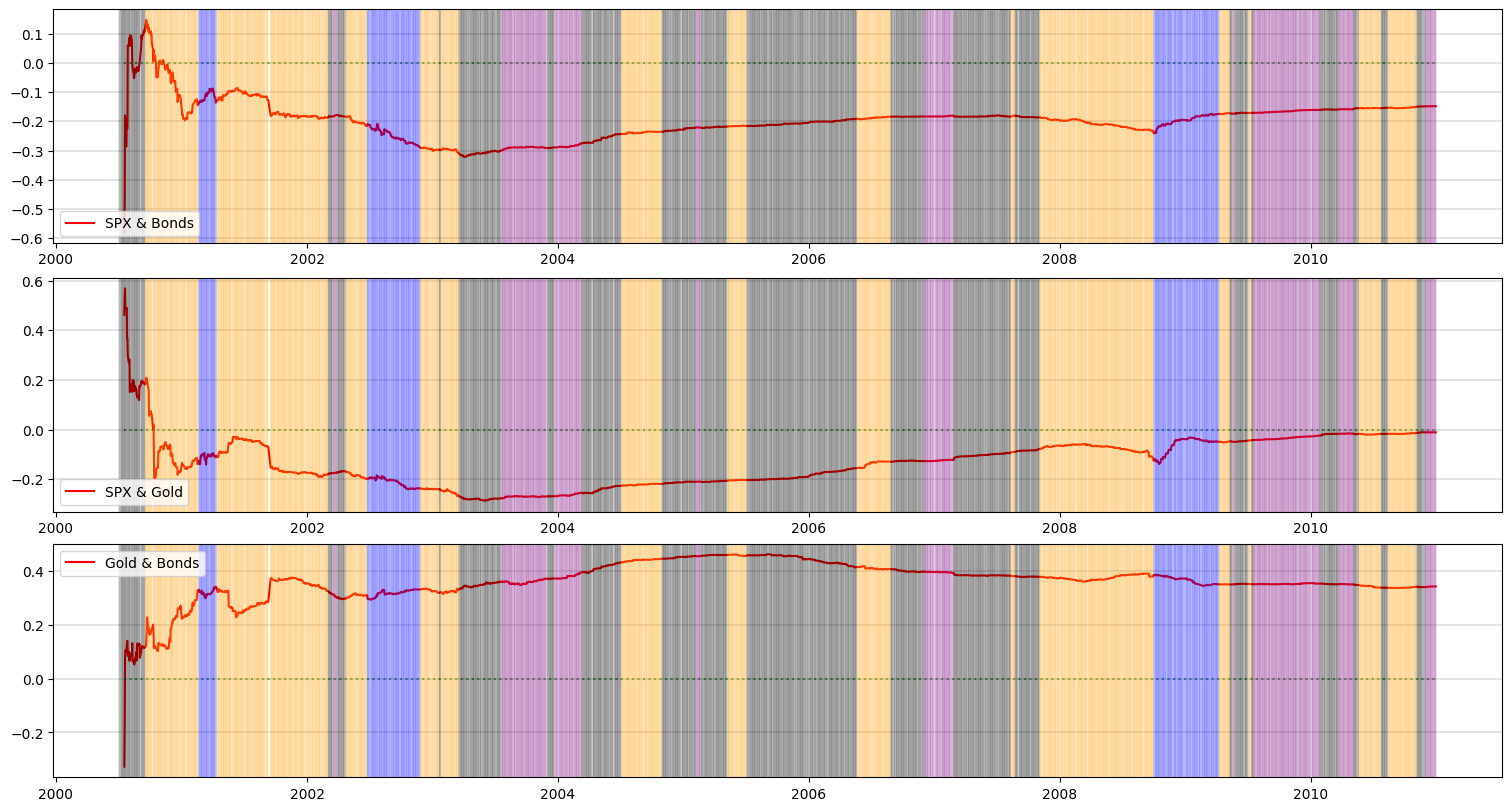

In [23]:
alpha = 0.1
spx_bnd_exp = allAssets_6[["SPX_Ret", "Bnd_Ret", "Gld_Ret"]].expanding(10).corr().dropna().loc[(slice(None), ["SPX_Ret"]), ].droplevel(1).Bnd_Ret
spx_gld_exp = allAssets_6[["SPX_Ret", "Bnd_Ret", "Gld_Ret"]].expanding(10).corr().dropna().loc[(slice(None), ["SPX_Ret"]), ].droplevel(1).Gld_Ret
bnd_gld_exp = allAssets_6[["SPX_Ret", "Bnd_Ret", "Gld_Ret"]].expanding(10).corr().dropna().loc[(slice(None), ["Bnd_Ret"]), ].droplevel(1).Gld_Ret

fig, ax = plt.subplots(3, 1, figsize=(15, 8), constrained_layout=True, sharex=True)
ax[0].plot(spx_bnd_exp, label = "SPX & Bonds", color="red")
ax[0].legend()
ax[0].xaxis.set_tick_params(which='both', labelbottom=True)
ax[0].grid(axis='y', linewidth = 1.2, alpha = 0.4)
ax[0].hlines(y = 0, xmin = spx_bnd_exp.index[0], xmax = spx_bnd_exp.index[-1], alpha = 0.6, linestyle = "dotted", color="green")
for i in px_reg_6[px_reg_6.Regime == 0].index:
    ax[0].axvline(i, label = "Regime 1", color = cVal[0], alpha = alphaVal)

for i in px_reg_6[px_reg_6.Regime == 1].index:
    ax[0].axvline(i, label = "Regime 2", color = cVal[1], alpha = alphaVal)

for i in px_reg_6[px_reg_6.Regime == 2].index:
    ax[0].axvline(i, label = "Regime 3", color = cVal[2], alpha = alphaVal)

for i in px_reg_6[px_reg_6.Regime == 3].index:
    ax[0].axvline(i, label = "Regime 4", color = cVal[3], alpha = alphaVal)

ax[1].plot(spx_gld_exp, label = "SPX & Gold", color="red")
ax[1].legend()
ax[1].grid(axis='y', linewidth = 1.2, alpha = 0.4)
ax[1].xaxis.set_tick_params(which='both', labelbottom=True)
ax[1].hlines(y = 0, xmin = spx_gld_exp.index[0], xmax = spx_gld_exp.index[-1], alpha = 0.6, linestyle = "dotted", color="green")
for i in px_reg_6[px_reg_6.Regime == 0].index:
    ax[1].axvline(i, label = "Regime 1", color = cVal[0], alpha = alphaVal)

for i in px_reg_6[px_reg_6.Regime == 1].index:
    ax[1].axvline(i, label = "Regime 2", color = cVal[1], alpha = alphaVal)

for i in px_reg_6[px_reg_6.Regime == 2].index:
    ax[1].axvline(i, label = "Regime 3", color = cVal[2], alpha = alphaVal)

for i in px_reg_6[px_reg_6.Regime == 3].index:
    ax[1].axvline(i, label = "Regime 4", color = cVal[3], alpha = alphaVal)

ax[2].plot(bnd_gld_exp, label = "Gold & Bonds", color="red")
ax[2].legend()
ax[2].grid(axis='y', linewidth = 1.2, alpha = 0.4)
ax[2].xaxis.set_tick_params(which='both', labelbottom=True)
ax[2].hlines(y = 0, xmin = bnd_gld_exp.index[0], xmax = bnd_gld_exp.index[-1], alpha = 0.6, linestyle = "dotted", color="green")
for i in px_reg_6[px_reg_6.Regime == 0].index:
    ax[2].axvline(i, label = "Regime 1", color = cVal[0], alpha = alphaVal)

for i in px_reg_6[px_reg_6.Regime == 1].index:
    ax[2].axvline(i, label = "Regime 2", color = cVal[1], alpha = alphaVal)

for i in px_reg_6[px_reg_6.Regime == 2].index:
    ax[2].axvline(i, label = "Regime 3", color = cVal[2], alpha = alphaVal)

for i in px_reg_6[px_reg_6.Regime == 3].index:
    ax[2].axvline(i, label = "Regime 4", color = cVal[3], alpha = alphaVal)

In [24]:
corr_spx_0_roll = allAssets_6[allAssets_6.Shifted_Reg == 0][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]].rolling(20).corr().dropna().loc[(slice(None), ["SPX_Ret"]), ].droplevel(1)
corr_bnd_0_roll = allAssets_6[allAssets_6.Shifted_Reg == 0][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]].rolling(20).corr().dropna().loc[(slice(None), ["Bnd_Ret"]), ].droplevel(1)

corr_spx_1_roll = allAssets_6[allAssets_6.Shifted_Reg == 1][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]].rolling(20).corr().dropna().loc[(slice(None), ["SPX_Ret"]), ].droplevel(1)
corr_bnd_1_roll = allAssets_6[allAssets_6.Shifted_Reg == 1][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]].rolling(20).corr().dropna().loc[(slice(None), ["Bnd_Ret"]), ].droplevel(1)

corr_spx_2_roll = allAssets_6[allAssets_6.Shifted_Reg == 2][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]].rolling(20).corr().dropna().loc[(slice(None), ["SPX_Ret"]), ].droplevel(1)
corr_bnd_2_roll = allAssets_6[allAssets_6.Shifted_Reg == 2][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]].rolling(20).corr().dropna().loc[(slice(None), ["Bnd_Ret"]), ].droplevel(1)

corr_spx_3_roll = allAssets_6[allAssets_6.Shifted_Reg == 3][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]].rolling(20).corr().dropna().loc[(slice(None), ["SPX_Ret"]), ].droplevel(1)
corr_bnd_3_roll = allAssets_6[allAssets_6.Shifted_Reg == 3][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]].rolling(20).corr().dropna().loc[(slice(None), ["Bnd_Ret"]), ].droplevel(1)

corr_spx_0_exp = allAssets_6[allAssets_6.Shifted_Reg == 0][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]].expanding(20).corr().dropna().loc[(slice(None), ["SPX_Ret"]), ].droplevel(1)
corr_bnd_0_exp = allAssets_6[allAssets_6.Shifted_Reg == 0][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]].expanding(20).corr().dropna().loc[(slice(None), ["Bnd_Ret"]), ].droplevel(1)

corr_spx_1_exp = allAssets_6[allAssets_6.Shifted_Reg == 1][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]].expanding(20).corr().dropna().loc[(slice(None), ["SPX_Ret"]), ].droplevel(1)
corr_bnd_1_exp = allAssets_6[allAssets_6.Shifted_Reg == 1][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]].expanding(20).corr().dropna().loc[(slice(None), ["Bnd_Ret"]), ].droplevel(1)

corr_spx_2_exp = allAssets_6[allAssets_6.Shifted_Reg == 2][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]].expanding(20).corr().dropna().loc[(slice(None), ["SPX_Ret"]), ].droplevel(1)
corr_bnd_2_exp = allAssets_6[allAssets_6.Shifted_Reg == 2][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]].expanding(20).corr().dropna().loc[(slice(None), ["Bnd_Ret"]), ].droplevel(1)

corr_spx_3_exp = allAssets_6[allAssets_6.Shifted_Reg == 3][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]].expanding(20).corr().dropna().loc[(slice(None), ["SPX_Ret"]), ].droplevel(1)
corr_bnd_3_exp = allAssets_6[allAssets_6.Shifted_Reg == 3][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]].expanding(20).corr().dropna().loc[(slice(None), ["Bnd_Ret"]), ].droplevel(1)

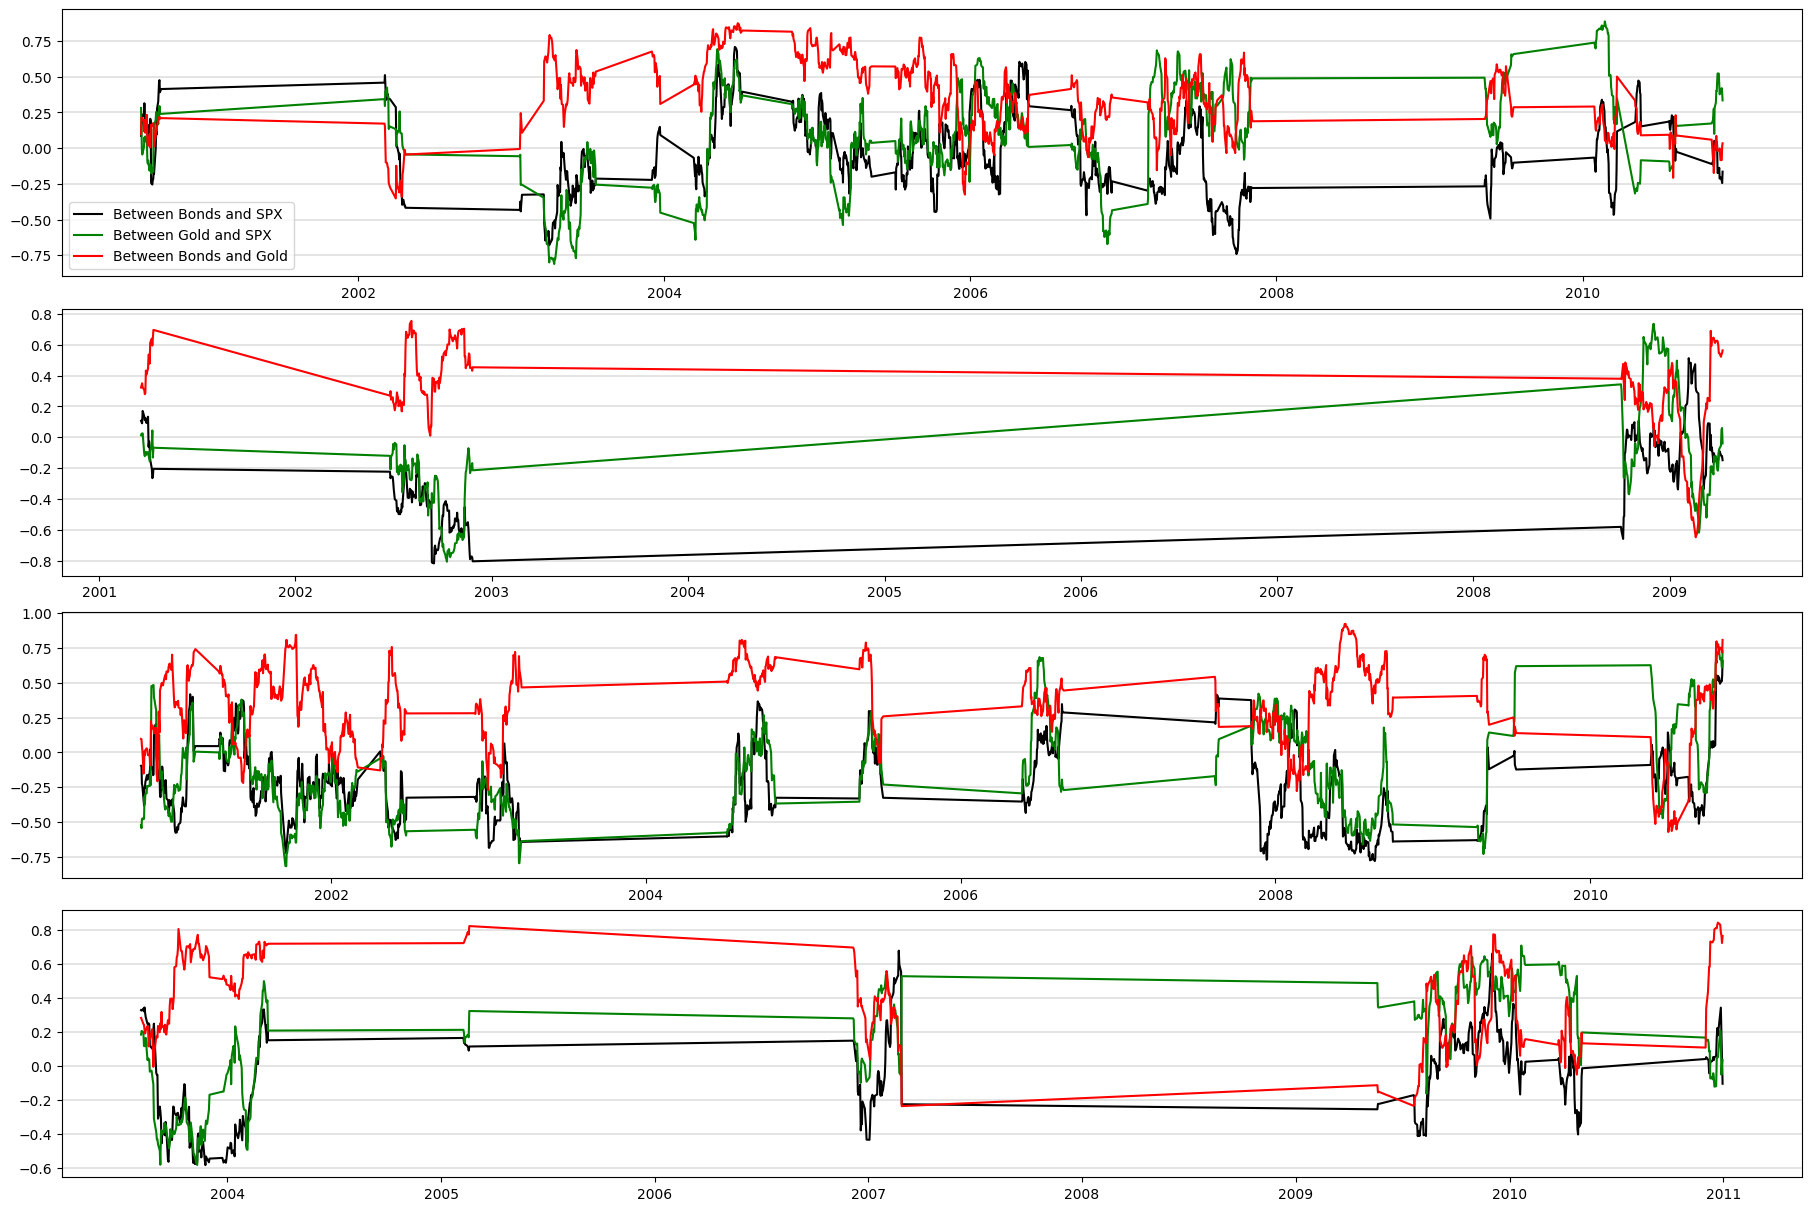

In [25]:
fig, ax = plt.subplots(4, 1, figsize=(18, 12), constrained_layout=True)

ax[0].plot(corr_spx_0_roll.Bnd_Ret, label = "Between Bonds and SPX", color = "black")
ax[0].plot(corr_spx_0_roll.Gld_Ret, label = "Between Gold and SPX", color = "green")
ax[0].plot(corr_bnd_0_roll.Gld_Ret, label = "Between Bonds and Gold", color = "red")
ax[0].grid(axis='y', linewidth = 1.2, alpha = 0.4)
ax[0].legend()

ax[1].plot(corr_spx_1_roll.Bnd_Ret, label = "Between Bonds and SPX", color = "black")
ax[1].plot(corr_spx_1_roll.Gld_Ret, label = "Between Gold and SPX", color = "green")
ax[1].plot(corr_bnd_1_roll.Gld_Ret, label = "Between Bonds and Gold", color = "red")
ax[1].grid(axis='y', linewidth = 1.2, alpha = 0.4)

ax[2].plot(corr_spx_2_roll.Bnd_Ret, label = "Between Bonds and SPX", color = "black")
ax[2].plot(corr_spx_2_roll.Gld_Ret, label = "Between Gold and SPX", color = "green")
ax[2].plot(corr_bnd_2_roll.Gld_Ret, label = "Between Bonds and Gold", color = "red")
ax[2].grid(axis='y', linewidth = 1.2, alpha = 0.4)

ax[3].plot(corr_spx_3_roll.Bnd_Ret, label = "Between Bonds and SPX", color = "black")
ax[3].plot(corr_spx_3_roll.Gld_Ret, label = "Between Gold and SPX", color = "green")
ax[3].plot(corr_bnd_3_roll.Gld_Ret, label = "Between Bonds and Gold", color = "red")
ax[3].grid(axis='y', linewidth = 1.2, alpha = 0.4)

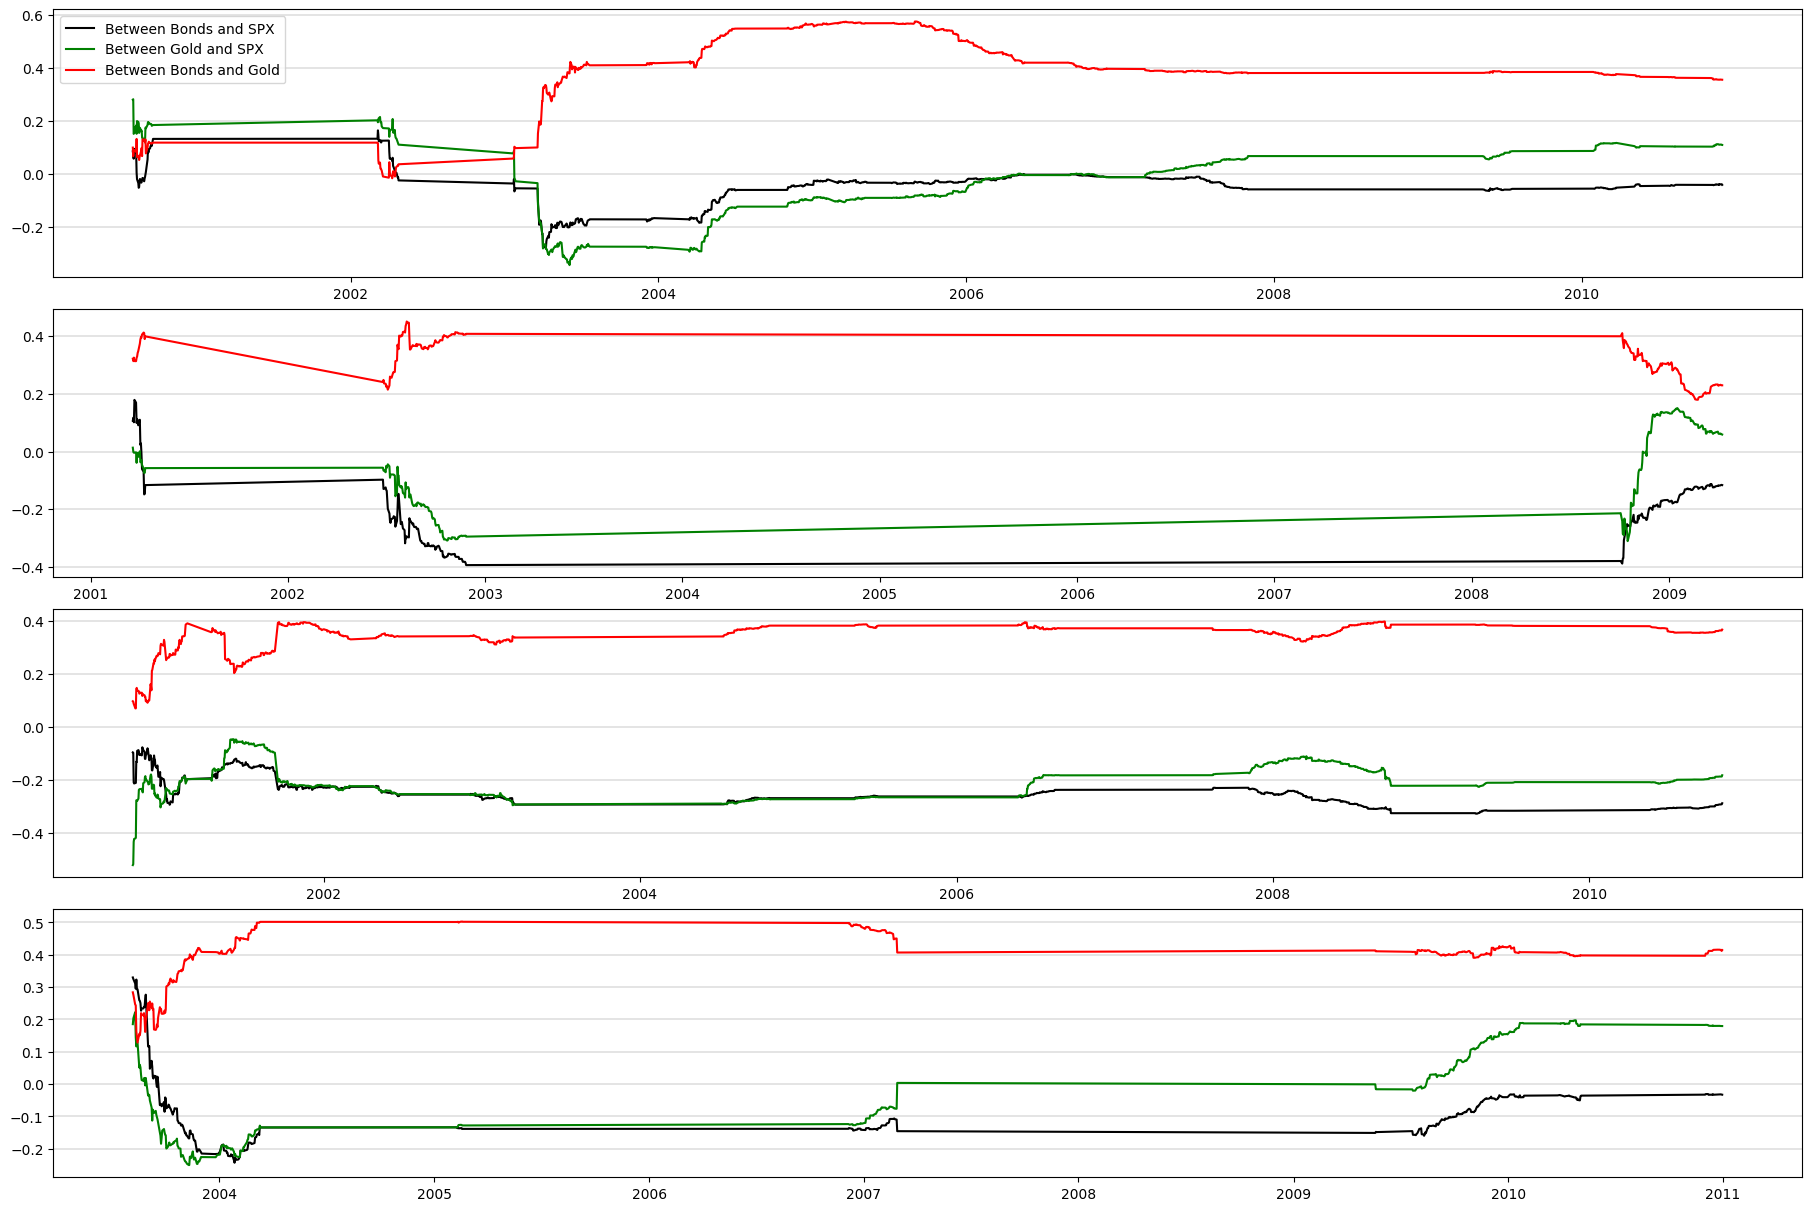

In [26]:
fig, ax = plt.subplots(4, 1, figsize=(18, 12), constrained_layout=True)

ax[0].plot(corr_spx_0_exp.Bnd_Ret, label = "Between Bonds and SPX", color = "black")
ax[0].plot(corr_spx_0_exp.Gld_Ret, label = "Between Gold and SPX", color = "green")
ax[0].plot(corr_bnd_0_exp.Gld_Ret, label = "Between Bonds and Gold", color = "red")
ax[0].grid(axis='y', linewidth = 1.2, alpha = 0.4)
ax[0].legend()

ax[1].plot(corr_spx_1_exp.Bnd_Ret, label = "Between Bonds and SPX", color = "black")
ax[1].plot(corr_spx_1_exp.Gld_Ret, label = "Between Gold and SPX", color = "green")
ax[1].plot(corr_bnd_1_exp.Gld_Ret, label = "Between Bonds and Gold", color = "red")
ax[1].grid(axis='y', linewidth = 1.2, alpha = 0.4)

ax[2].plot(corr_spx_2_exp.Bnd_Ret, label = "Between Bonds and SPX", color = "black")
ax[2].plot(corr_spx_2_exp.Gld_Ret, label = "Between Gold and SPX", color = "green")
ax[2].plot(corr_bnd_2_exp.Gld_Ret, label = "Between Bonds and Gold", color = "red")
ax[2].grid(axis='y', linewidth = 1.2, alpha = 0.4)

ax[3].plot(corr_spx_3_exp.Bnd_Ret, label = "Between Bonds and SPX", color = "black")
ax[3].plot(corr_spx_3_exp.Gld_Ret, label = "Between Gold and SPX", color = "green")
ax[3].plot(corr_bnd_3_exp.Gld_Ret, label = "Between Bonds and Gold", color = "red")
ax[3].grid(axis='y', linewidth = 1.2, alpha = 0.4)

In [27]:
reg1_corr = allAssets_6[allAssets_6.Shifted_Reg == 0][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]].corr()
reg2_corr = allAssets_6[allAssets_6.Shifted_Reg == 1][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]].corr()
reg3_corr = allAssets_6[allAssets_6.Shifted_Reg == 2][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]].corr()
reg4_corr = allAssets_6[allAssets_6.Shifted_Reg == 3][["SPX_Ret", "Bnd_Ret", "Gld_Ret"]].corr()

### From Regime 0 to Regime 2

In [28]:
from scipy.spatial import distance_matrix

#### Trend Following

In [7]:
trend_following_sig = port1[["SPX Index"]].loc[:'2010-12-31'].copy()
trend_following_sig

SPX Index
date                 
2000-01-03    1455.22
2000-01-04    1399.42
2000-01-05    1402.11
2000-01-06    1403.45
2000-01-07    1441.47
...               ...
2010-12-27    1257.54
2010-12-28    1258.51
2010-12-29    1259.78
2010-12-30    1257.88
2010-12-31    1257.64

[2766 rows x 1 columns]

Text(0.5, 0.98, 'Trend Following (50DMA)')

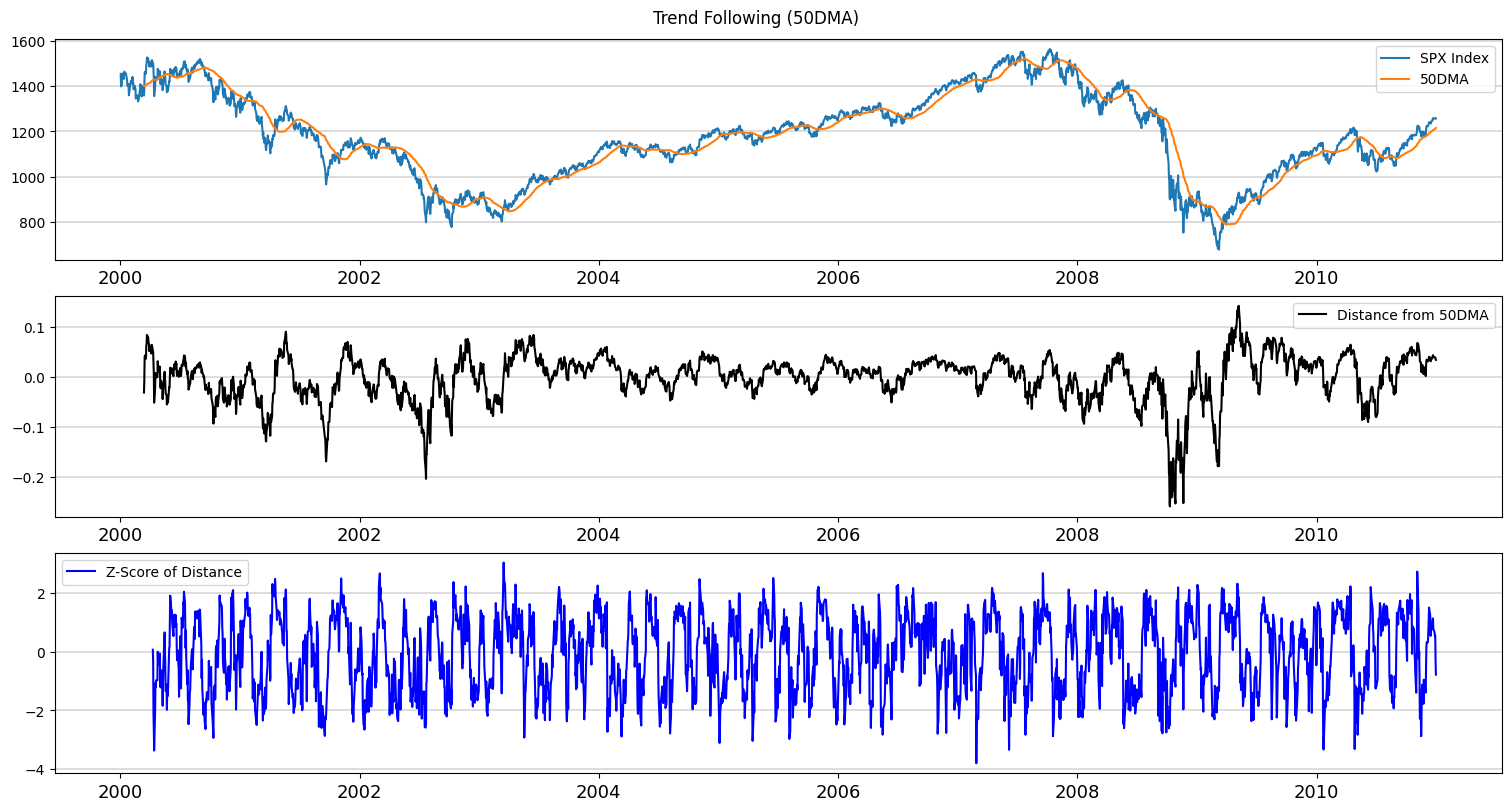

In [8]:
trend_following_sig["50DMA"] = trend_following_sig[["SPX Index"]].rolling(50).mean()
trend_following_sig["dist_50dma"] = (trend_following_sig["SPX Index"] / trend_following_sig["50DMA"])  - 1
z_50dma_dist_obj = trend_following_sig["dist_50dma"].rolling(20)
z_50dma_dist_z = (trend_following_sig["dist_50dma"] - z_50dma_dist_obj.mean()) / z_50dma_dist_obj.std()

fig, ax = plt.subplots(3, 1, figsize = (15, 8), constrained_layout = True, sharex = True)

ax[0].plot(trend_following_sig["SPX Index"], label = "SPX Index")
ax[0].plot(trend_following_sig["50DMA"], label = "50DMA")
ax[0].grid(axis='y', linewidth=1.2, alpha=0.5)
ax[0].legend()
ax[0].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)
ax[1].plot(trend_following_sig["dist_50dma"], label = "Distance from 50DMA", color = "black")
ax[1].grid(axis='y', linewidth=1.2, alpha=0.5)
ax[1].legend()
ax[1].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)
ax[2].plot(z_50dma_dist_z, label = "Z-Score of Distance", color = "blue")
ax[2].grid(axis='y', linewidth=1.2, alpha=0.5)
ax[2].legend()
ax[2].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)
fig.suptitle("Trend Following (50DMA)")

Text(0.5, 0.98, 'Trend Following (200DMA)')

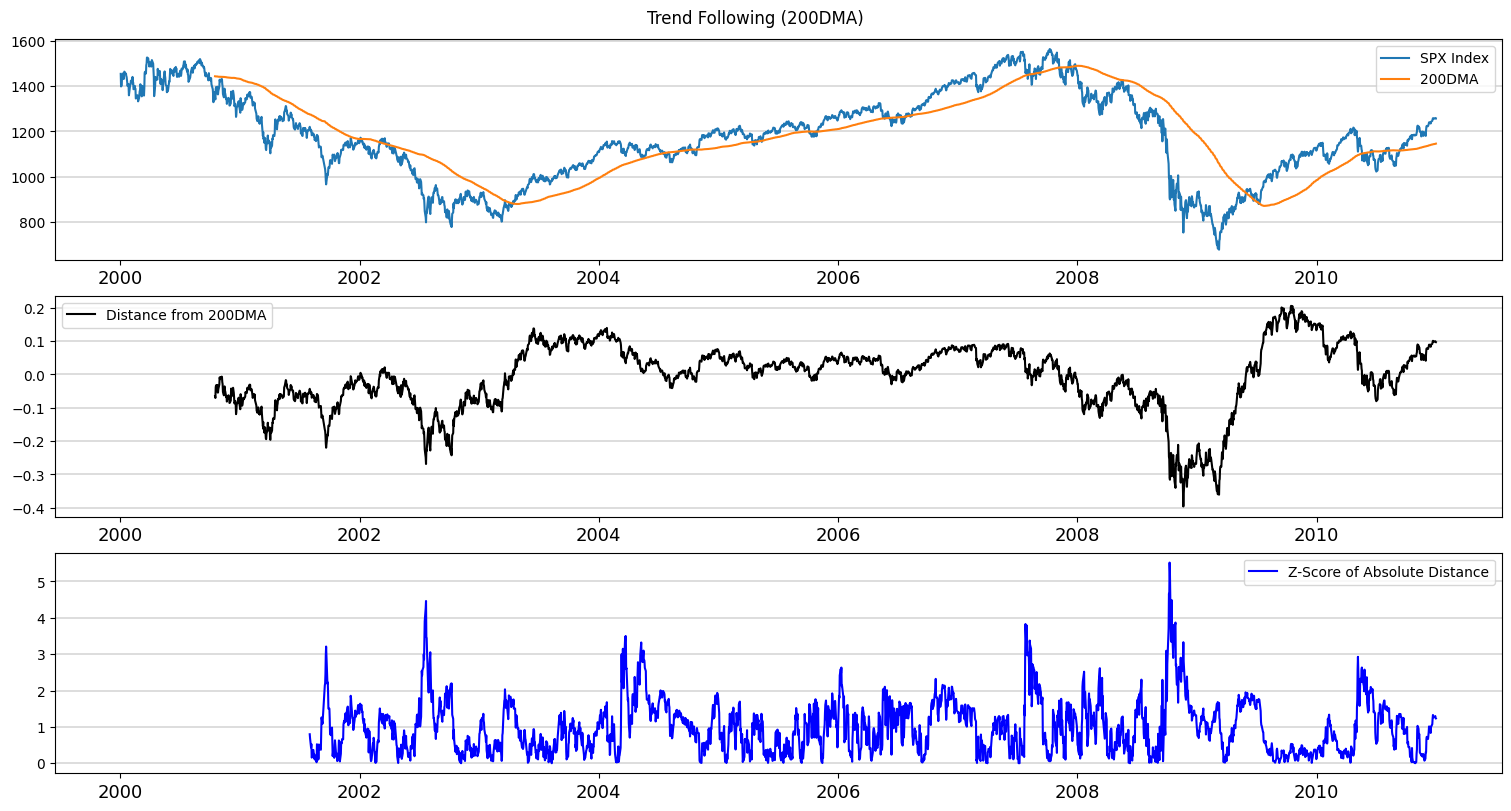

In [9]:
trend_following_sig["200DMA"] = trend_following_sig[["SPX Index"]].rolling(200).mean()
trend_following_sig["dist_200dma"] = (trend_following_sig["SPX Index"] / trend_following_sig["200DMA"])  - 1
z_200dma_dist_obj = trend_following_sig["dist_200dma"].abs().rolling(200)
trend_following_sig["Z"] = (trend_following_sig["dist_200dma"].abs() - z_200dma_dist_obj.mean()) / z_200dma_dist_obj.std()

# Create signal
trend_following_sig["Direction"] = np.where(trend_following_sig.dist_200dma >= 0, 1, -1)
# trend_following_sig["Size"] = np.where(trend_following_sig.Z > 1, np.where(trend_following_sig.Z > 2, np.where(trend_following_sig.Z > 2, np.where(trend_following_sig.Z > 3, 3, 5), 3), 2), 1)

fig, ax = plt.subplots(3, 1, figsize = (15, 8), constrained_layout = True, sharex = True)

ax[0].plot(trend_following_sig["SPX Index"], label = "SPX Index")
ax[0].plot(trend_following_sig["200DMA"], label = "200DMA")
ax[0].grid(axis='y', linewidth=1.2, alpha=0.5)
ax[0].legend()
ax[0].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)
ax[1].plot(trend_following_sig["dist_200dma"], label = "Distance from 200DMA", color = "black")
ax[1].grid(axis='y', linewidth=1.2, alpha=0.5)
ax[1].legend()
ax[1].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)

ax[2].plot(trend_following_sig.Z.abs(), label = "Z-Score of Absolute Distance", color = "blue")
# ax[2].plot(trend_following_sig.Size, label = "Position Sizing", linestyle = "dotted", color = "red")
ax[2].grid(axis='y', linewidth=1.2, alpha=0.5)
ax[2].legend()
ax[2].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)
fig.suptitle("Trend Following (200DMA)")

### Basic Momentum Strategy

In [148]:
px_mom ['Signal'] = np.where(px_mom.Mth_Prior_1_Return >= 0, 1, 0)
px_mom_3['Signal'] = np.where(px_mom_3.Mth_Prior_3_Return >= 0, 1, 0)
px_mom_6['Signal'] = np.where(px_mom_6.Mth_Prior_6_Return >= 0, 1, 0)

sig_1_mo = px_mom.Signal
sig_1_mo.name = 'PX_Mom_1'
sig_3_mo = px_mom_3.Signal
sig_3_mo.name = 'PX_Mom_3'
sig_6_mo = px_mom_6.Signal
sig_6_mo.name = 'PX_Mom_6'

all_px_mom_sig = pd.concat([sig_1_mo, sig_3_mo, sig_6_mo], axis=1)
all_px_mom_sig['Sig_Strength'] = all_px_mom_sig.sum(axis=1)
all_px_mom_sig['Sig_Strength_Adj'] = all_px_mom_sig['Sig_Strength'].shift(1)
all_px_mom_sig['SPX_ret'] = port1[["SPX Index"]].pct_change()
all_px_mom_sig.dropna(inplace=True)
all_px_mom_sig['Positioning'] = all_px_mom_sig['Sig_Strength_Adj'].map({0 : 0.1, 1 : 0.4, 2 : 0.6, 3: 0.9})
all_px_mom_sig['Portfolio'] = all_px_mom_sig['Positioning'] * all_px_mom_sig['SPX_ret']
all_px_mom_sig

PX_Mom_1  PX_Mom_3  PX_Mom_6  Sig_Strength  Sig_Strength_Adj  \
date                                                                       
2000-07-03         0       0.0       1.0           1.0               1.0   
2000-07-05         0       0.0       1.0           1.0               1.0   
2000-07-06         0       0.0       1.0           1.0               1.0   
2000-07-07         1       0.0       1.0           2.0               1.0   
2000-07-10         1       0.0       1.0           2.0               2.0   
...              ...       ...       ...           ...               ...   
2010-12-27         1       1.0       1.0           3.0               3.0   
2010-12-28         1       1.0       1.0           3.0               3.0   
2010-12-29         1       1.0       1.0           3.0               3.0   
2010-12-30         1       1.0       1.0           3.0               3.0   
2010-12-31         1       1.0       1.0           3.0               3.0   

             SPX_ret  Positioning  Portfolio  
date                                          
2000-07-03  0.010271          0.4   0.004108  
2000-07-05 -0.015862          0.4  -0.006345  
2000-07-06  0.007219          0.4   0.002888  
2000-07-07  0.015261          0.4   0.006104  
2000-07-10 -0.002218          0.6  -0.001331  
...              ...          ...        ...  
2010-12-27  0.000613          0.9   0.000551  
2010-12-28  0.000771          0.9   0.000694  
2010-12-29  0.001009          0.9   0.000908  
2010-12-30 -0.001508          0.9  -0.001357  
2010-12-31 -0.000191          0.9  -0.000172  

[2640 rows x 8 columns]

In [149]:
exportPerformanceMetrics(all_px_mom_sig["Portfolio"], all_px_mom_sig["SPX_ret"])

Strategy Benchmark
Performance Metrics (2000-07-03 till 2010-12-31)                   
CAGR %                                              1.01%    -1.38%
Volatility                                          8.82%    21.74%
Sharpe Ratio                                         0.11     -0.06
Max Drawdown %                                    -24.42%   -56.78%
Return/MaxDrawdown                                   0.04      0.02

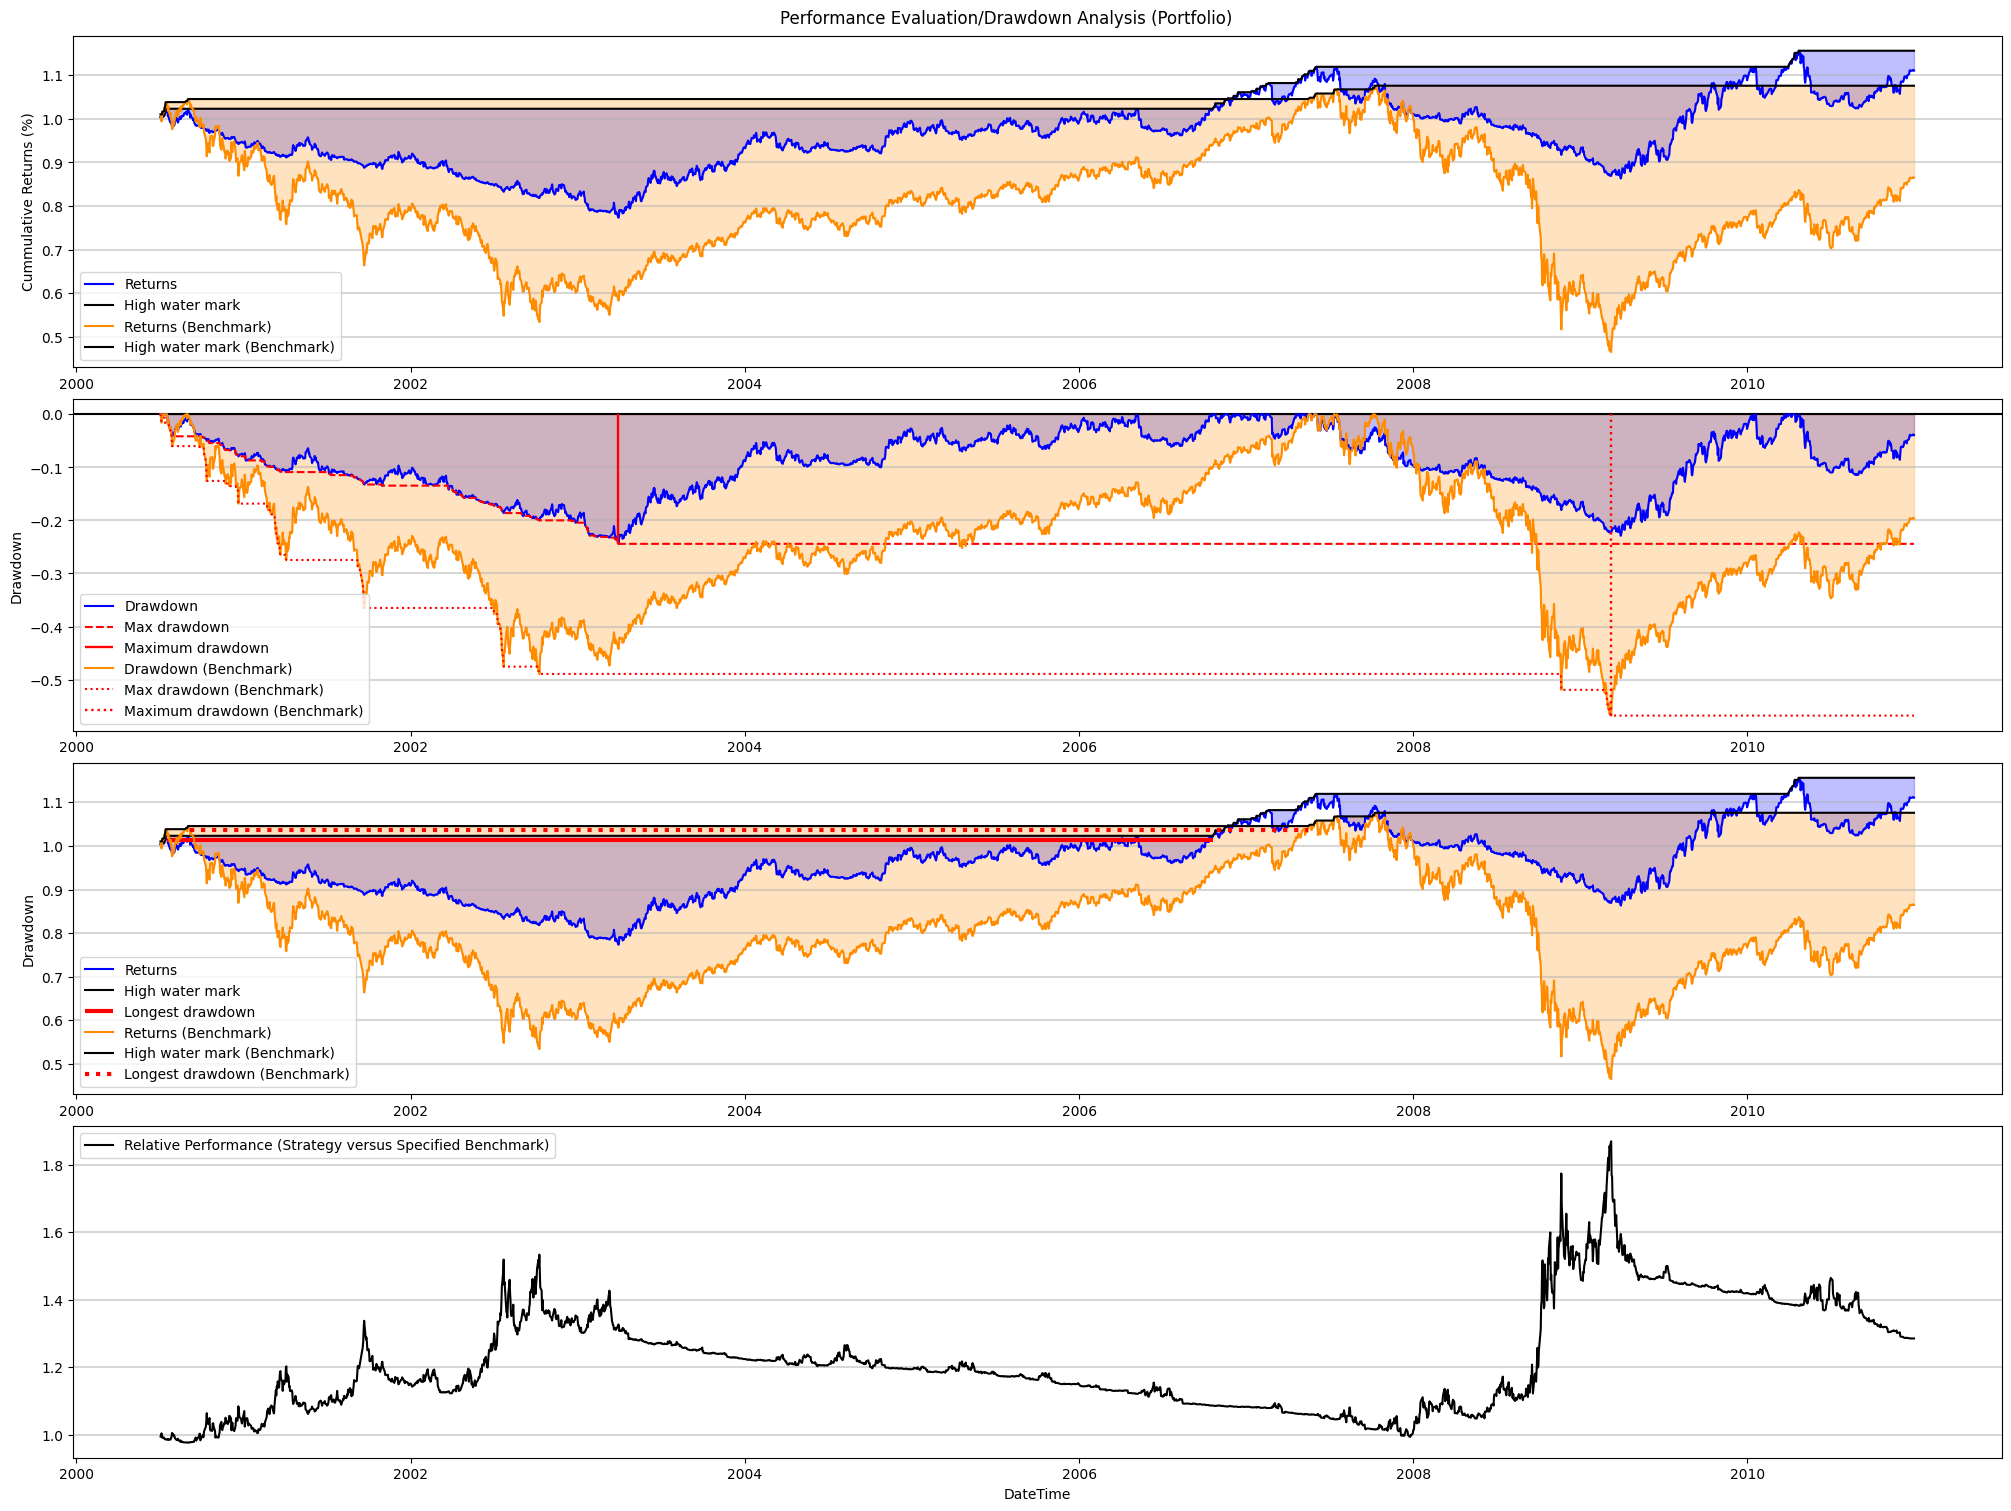

In [150]:
drawdownCharts(all_px_mom_sig["Portfolio"], benchmark = all_px_mom_sig["SPX_ret"], includeBenchmark = True, showPlot=True)

In [58]:
#### Tactical can evolve
#### Strategic just fixed - observe eco and macro data
####  FIx allocation

In [59]:
#### 25bps turnover cost

#### MCMC 

In [ ]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()

        # Compute prior probability of current and proposed mu
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)

        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal

        # Accept proposal?
        p_accept = p_proposal / p_current

        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept

        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)

        if accept:
            # Update position
            mu_current = mu_proposal

        posterior.append(mu_current)

    return np.array(posterior)

# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'

    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))

    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))

    # Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))

    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    #plt.legend()